<a href="https://colab.research.google.com/github/guimalcantara/-Estrategia_Trading_NLP_e_Analise_De_Sentimento/blob/main/Estrategia_Trading_NLP_e_Analise_De_Sentimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP e Estratégia de Negociação Baseada em Análise de Sentimento


> Adicionar aspas



Neste estudo de caso, usamos NLP para construir uma estratégia de negociação combinando alguns dos conceitos que abordamos em alguns dos capítulos anteriores.




<a id='1'></a>
# 2. Introdução - Carregando os dados e pacotes python


<a id='2.1'></a>
## 2.1. Carregando os pacotes python

Como primeiro passo, verificamos se os pacotes adicionais necessários estão presentes, caso contrário, instalamos. Eles são verificados separadamente, pois não estão incluídos em requirement.txt, pois não são usados para todos os estudos de caso.

In [45]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'nltk', 'spacy', 'textblob', 'backtrader'}
missing = required - installedPackages
if missing:
    !pip install --upgrade pip #The line should be indented
    !pip install nltk==3.9.1  #The line should be indented
    !pip install textblob==0.17.1 #The line should be indented
    !pip install spacy==3.7.2 #The line should be indented
    !pip install backtrader==1.9.74.123 #The line should be indented
    !pip install tensorflow
    !pip install keras
    !pip install yfinance --upgrade

/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [33]:
# Baixa os modelos de linguagem SpaCy necessários para NLP
!python -m spacy download pt_core_news_lg
!python -m spacy download pt_core_news_sm
!python -m spacy download en_core_web_lg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 24.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 37.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 42.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [46]:

# DOWNLOADS E CONFIGURAÇÃO DO AMBIENTE NLP

import nltk
import spacy
import nltk.data
from textblob import TextBlob

# Download de recursos do NLTK
nltk.download('punkt')
nltk.download('vader_lexicon')

# Dicionário para armazenar os modelos carregados
spacy_models = {}

# Função segura para carregar modelos do spaCy
def carregar_modelo_spacy(nome_modelo):
    try:
        return spacy.load(nome_modelo)
    except OSError:
        print(f"Modelo {nome_modelo} não encontrado. Instale com:")
        print(f"!python -m spacy download {nome_modelo}")
        return None

# Carrega os modelos em português
spacy_models["pt"] = carregar_modelo_spacy("pt_core_news_lg") or carregar_modelo_spacy("pt_core_news_sm")

# Carrega o modelo em inglês (obrigatório para headlines internacionais)
spacy_models["en"] = carregar_modelo_spacy("en_core_web_lg")

# Verifica se os modelos foram carregados corretamente
assert spacy_models["pt"] is not None, "Modelo SpaCy para português não carregado."
assert spacy_models["en"] is not None, "Modelo SpaCy para inglês não carregado."

# ========================================
# TESTES DE FUNCIONAMENTO DOS MODELOS
# ========================================

# Testa com uma frase em português
doc_pt = spacy_models["pt"]("Esta é uma frase de exemplo.")
print("Modelo PT:", [(w.text, w.pos_) for w in doc_pt])

# Testa com uma frase em inglês
doc_en = spacy_models["en"]("This is a sample sentence.")
print("Modelo EN:", [(w.text, w.pos_) for w in doc_en])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Modelo PT: [('Esta', 'PRON'), ('é', 'AUX'), ('uma', 'DET'), ('frase', 'NOUN'), ('de', 'ADP'), ('exemplo', 'NOUN'), ('.', 'PUNCT')]
Modelo EN: [('This', 'PRON'), ('is', 'AUX'), ('a', 'DET'), ('sample', 'NOUN'), ('sentence', 'NOUN'), ('.', 'PUNCT')]


Vamos carregar as bibliotecas

As bibliotecas **`scikit-learn`** (como `MLPClassifier`, `RandomForestClassifier`, `LogisticRegression`, etc.) são compatíveis com qualquer idioma, incluindo o **português brasileiro**. Isso ocorre porque os modelos de aprendizado de máquina da `scikit-learn` não são sensíveis ao idioma, mas sim às características dos dados (números, textos, etc.).

### Como funciona a compatibilidade com o português:

1. **Modelos de classificação**:

   * Os classificadores como **`MLPClassifier`**, **`RandomForestClassifier`**, **`LogisticRegression`**, etc., funcionam com **qualquer tipo de dado**, incluindo textos em português. No caso de textos, o que importa são as **features (características)** extraídas do texto, como a contagem de palavras, a frequência de termos, ou a presença de palavras específicas.
   * O modelo não "entende" diretamente o idioma, mas trabalha com **representações numéricas dos dados**, como as que você extrai ao usar técnicas como **TF-IDF** ou **Word Embeddings** (como **Word2Vec**, **GloVe**, ou **FastText**).

2. **Extração de características do texto**:
   Para usar esses classificadores com texto em português, é necessário representar as palavras ou frases em uma forma que o modelo consiga entender. As técnicas comuns incluem:

   * **Tokenização**: Dividir o texto em palavras ou unidades menores.
   * **Vetorização**: Transformar essas palavras em números, utilizando métodos como:

     * **Contagem de palavras** (`CountVectorizer`)
     * **TF-IDF** (`TfidfVectorizer`)
     * **Word Embeddings** (como **Word2Vec**, **GloVe**, ou **FastText**).

3. **Análise de Sentimentos**:

   * Quando você usa **análise de sentimentos** ou **classificação de texto** com essas bibliotecas, você geralmente treina o modelo com **exemplos de textos rotulados** (por exemplo, tweets ou resenhas em português). O modelo aprenderá padrões, mas o treinamento depende de como você prepara os dados de entrada.

4. **Resultados e Avaliação**:

   * As métricas como **`classification_report`**, **`confusion_matrix`**, e **`accuracy_score`** também são independentes do idioma. Elas avaliam a performance do modelo com base nos dados de entrada (no caso, textos em português) e as classes preditivas.
   * Essas métricas funcionam para qualquer conjunto de dados, independentemente de estar em inglês, português ou outro idioma.

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Conjunto de manchetes sintéticas simulando notícias financeiras
texts = [
    "Ibovespa sobe com otimismo sobre corte de juros",
    "Dólar recua após anúncio do Banco Central",
    "Petrobras tem lucro recorde no segundo trimestre",
    "Mercado reage mal à nova política fiscal",
    "Ações da Vale despencam após queda no minério"
]

# Criando um Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Convertendo os textos para sequências de números
sequences = tokenizer.texts_to_sequences(texts)
print("Sequências:", sequences)

# Visualizando o vocabulário gerado pelo Tokenizer
print("Vocabulário:", tokenizer.word_index)



Sequências: [[3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 1, 13, 14, 15, 16], [17, 18, 19, 20, 2, 21, 22], [23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 1, 34, 2, 35]]
Vocabulário: {'após': 1, 'no': 2, 'ibovespa': 3, 'sobe': 4, 'com': 5, 'otimismo': 6, 'sobre': 7, 'corte': 8, 'de': 9, 'juros': 10, 'dólar': 11, 'recua': 12, 'anúncio': 13, 'do': 14, 'banco': 15, 'central': 16, 'petrobras': 17, 'tem': 18, 'lucro': 19, 'recorde': 20, 'segundo': 21, 'trimestre': 22, 'mercado': 23, 'reage': 24, 'mal': 25, 'à': 26, 'nova': 27, 'política': 28, 'fiscal': 29, 'ações': 30, 'da': 31, 'vale': 32, 'despencam': 33, 'queda': 34, 'minério': 35}


In [49]:
# Bibliotecas para Processamento de Linguagem Natural (PLN)
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')  # Baixa o léxico necessário para análise de sentimentos
import csv
import pandas as pd

# Carregue o modelo de linguagem
import pt_core_news_lg
nlp = pt_core_news_lg.load()
import en_core_web_lg
nlp_en = en_core_web_lg.load()
# Bibliotecas para processar manchetes de notícias
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay  # Offset de negócios (útil para datas)
from scipy.stats.mstats import winsorize  # Método de Winsorização (para lidar com valores extremos)
from copy import copy  # Criação de cópias superficiais de objetos

# Bibliotecas para classificação e modelagem de sentimentos
from sklearn.neural_network import MLPClassifier  # Classificador de redes neurais
from sklearn.ensemble import RandomForestClassifier  # Classificador de floresta aleatória
from sklearn.linear_model import LogisticRegression  # Regressão logística
from sklearn.tree import DecisionTreeClassifier  # Classificador de árvore de decisão
from sklearn.neighbors import KNeighborsClassifier  # K-vizinhos mais próximos
from sklearn.svm import SVC  # Máquinas de vetores de suporte (SVM)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Métricas de avaliação

# Bibliotecas para modelagem de sentimento com redes neurais (Deep Learning)
#from keras.preprocessing.text import Tokenizer  # Tokenização de texto para redes neurais - Commented out keras import
from tensorflow.keras.preprocessing.text import Tokenizer  # Usando tensorflow.keras ao invés de keras
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Preenchimento de sequências de texto
from tensorflow.keras.models import Sequential  # Modelo sequencial de redes neurais
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding  # Camadas de redes neurais, incluindo a camada de embedding
from tensorflow.keras.layers import Embedding  # Camada de embedding para palavras

# Bibliotecas para análise estatística e visualização
import statsmodels.api as sm  # Análise estatística
import seaborn as sns  # Visualização de dados
import pandas as pd  # Manipulação de dados
import numpy as np  # Funções matemáticas e de álgebra linear
import datetime  # Manipulação de datas e horas
from datetime import date  # Trabalhando com datas
import matplotlib.pyplot as plt  # Visualização de gráficos
import yfinance as yf  # Para obter dados financeiros de ações

# Bibliotecas adicionais
import json  # Manipulação de dados em formato JSON
import zipfile  # Trabalhar com arquivos ZIP
import os.path  # Manipulação de caminhos de arquivos
import sys  # Funções do sistema operacional



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [50]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2.2'></a>
## 2.2. Carregando os dados de preços das ações

Os dados de preços das ações são carregados nesta etapa do Yahoo Finance. Os dados carregados são salvos em csv para uso posterior.

In [16]:
import yfinance as yf
import pandas as pd
import os

# Mapeamento manual de dias da semana em português
dias_semana_pt = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

# Lista de tickers brasileiros
tickers = ['VALE3.SA', 'PETR4.SA', 'ITUB4.SA', 'BBAS3.SA']

# Período de análise
start = '2022-01-01'
end = '2024-12-31'

# Lista para acumular DataFrames
dados_completos = []

for ticker in tickers:
    ticker_yf = yf.Ticker(ticker)
    dados = ticker_yf.history(start=start, end=end)

    # Garante que o índice seja convertido em coluna
    dados = dados.reset_index()

    # Criação das colunas formatadas
    dados['Data'] = dados['Date'].dt.date.astype(str)
    dados['Hora'] = dados['Date'].dt.time.astype(str)
    dados['Dia_da_semana'] = dados['Date'].dt.day_name().map(dias_semana_pt)

    dados['Ticker'] = ticker

    # Seleciona e reordena colunas
    dados_formatado = dados[[
        'Data', 'Dia_da_semana',
        'Open', 'High', 'Low', 'Close',
        'Volume', 'Dividends', 'Stock Splits', 'Ticker'
    ]]

    dados_completos.append(dados_formatado)

# Concatenação final
df_final = pd.concat(dados_completos, ignore_index=True)

# Criação de diretório
os.makedirs("data", exist_ok=True)

# Caminhos dos arquivos
caminho_csv = "data/ReturnData.csv"
caminho_excel = "data/ReturnData.xlsx"

# Salvamento dos arquivos
df_final.to_csv(caminho_csv, sep='|', index=False)
df_final.to_excel(caminho_excel, index=False, engine='openpyxl')

# Exibição interativa (Google Colab)
from google.colab import data_table
data_table.enable_dataframe_formatter()
data_table.DataTable(df_final)

Os dados contêm os tickers e seus retornos. Na próxima etapa, limpamos os dados e garantimos que o ponto de partida seja 2022 e que os NAs nos dados sejam removidos.

<a id='3'></a>

# 3. Preparação dos Dados

Dividimos a preparação dos dados em algumas etapas da seguinte forma:
* Carregando e pré-processando os dados das notícias
* Preparando os dados combinados

<a id='3.1'></a>

## 3.1  Carregando e pré-processando os dados das notícias

Os dados das notícias são baixados do feed de notícias RSS e o arquivo é baixado no formato json e os arquivos json para diferentes datas são mantidos em uma pasta compactada.

## 3.1.1  Coleta Automatizada de Notícias Financeiras via RSS
## Coleta Automatizada de Notícias Financeiras via RSS

O script desenvolvido tem como objetivo central coletar notícias publicadas na internet relacionadas a ações brasileiras listadas na B3, utilizando a API RSS do Google News como canal de extração. Para tanto, emprega uma arquitetura em Python composta por módulos consagrados como `requests`, `pandas`, `BeautifulSoup` e `dateutil`, integrando técnicas de *web scraping*, manipulação de dados e limpeza textual.

### 1. Definição do Escopo Temporal e Semântico

Inicialmente, define-se um dicionário com os termos de busca associados a cada **ticker** de interesse (como `'VALE3.SA'`), permitindo múltiplas variações nomenclaturais relevantes para mecanismos de busca. O intervalo de coleta abrange um período fixo entre 1º de janeiro de 2022 e 31 de dezembro de 2024.

A seguir, o código gera **janelas temporais de 6 dias** consecutivos para modular a busca. Esta divisão busca contornar limitações de resposta dos serviços RSS e assegurar granularidade temporal adequada para análise posterior.

### 2. Consulta ao Google News RSS

Para cada janela de tempo e para cada ticker, é construída uma URL parametrizada com uma *query* em linguagem booleana — incluindo todos os termos relacionados ao ativo — e delimitadores temporais `after` e `before`. A requisição HTTP é feita com cabeçalho que simula um navegador, e os resultados são processados com o **BeautifulSoup**, que permite extrair título, descrição, data, horário e URL de cada notícia.

Além disso, a biblioteca `langdetect` é utilizada para inferir o idioma da manchete, o que é uma prática comum para filtrar ruídos em bases multilinguísticas. Todo esse processo é encapsulado em uma função robusta com tratamento de exceções para garantir continuidade da execução mesmo em casos de falha de rede ou estrutura HTML malformada.

### 3. Estruturação dos Dados

As notícias coletadas são armazenadas como dicionários em uma lista principal. Ao final, esse material é convertido em um `DataFrame` do pandas para facilitar operações de tratamento e análise.

#### Deduplicação e Limpeza

A deduplicação se dá com base em manchetes normalizadas (`headline_clean`), onde caracteres não alfanuméricos são removidos e o texto é transformado em minúsculas. A contagem de repetições é calculada por data e título, permitindo a ordenação por relevância.

### 4. Exportação dos Dados

Os dados únicos, organizados e limpos, são exportados em formato JSON, com codificação UTF-8 preservada (`force_ascii=False`) e estrutura orientada a registros. O arquivo final é salvo localmente na pasta `dados`.

### 5. Feedback ao Usuário

A aplicação fornece um resumo estatístico ao final da execução, indicando o número total de notícias únicas coletadas, o caminho do arquivo salvo e a distribuição de notícias por ticker.

---

## Considerações Técnicas

A abordagem é eficiente, modular e robusta. Utiliza técnicas idiomáticas de Python e boas práticas como:

* Modularização por funções;
* Uso de `try/except` para tolerância a falhas;
* Normalização textual para comparação semântica;
* Aplicação de `tqdm` para *feedback visual* com barra de progresso;
* Estrutura de dados bem organizada para exportação e uso posterior em análises de NLP ou modelagem financeira.

---



Coleta de notícias

In [34]:
!pip install -q beautifulsoup4 pandas python-dateutil langdetect tqdm

In [17]:
import os
import json
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm

# ===============================================================
# 1. DEFINIÇÃO DE TICKERS, TERMOS E PERÍODOS DE COLETA
# ===============================================================

termos_de_busca = {
    'VALE3.SA': ['VALE3', 'VALE3.SA', 'BVMF:VALE3'],
    'PETR4.SA': ['PETR4', 'PETR4.SA', 'BVMF:PETR4'],
    'ITUB4.SA': ['ITUB4', 'ITUB4.SA', 'BVMF:ITUB4'],
    'BBAS3.SA': ['BBAS3', 'BBAS3.SA', 'BVMF:BBAS3']
}

inicio_coleta = datetime.strptime('2022-01-01', '%Y-%m-%d')
fim_coleta    = datetime.strptime('2024-12-31', '%Y-%m-%d')

def gerar_periodos_mensais(start, end):
    periodos = []
    atual = start
    while atual < end:
        fim_mes = atual + relativedelta(months=1) - relativedelta(days=1)
        if fim_mes > end:
            fim_mes = end
        periodos.append((atual, fim_mes))
        atual = fim_mes + relativedelta(days=1)
    return periodos

periodos = gerar_periodos_mensais(inicio_coleta, fim_coleta)

# ===============================================================
# 2. COLETA E SALVAMENTO DE JSONS POR TICKER
# ===============================================================

os.makedirs("noticias_json", exist_ok=True)

def coletar_rss_google(ticker, termos, dt_inicio, dt_fim):
    query = "(" + " OR ".join([f'"{t}"' if ' ' in t else t for t in termos]) + ")"
    url = (
        'https://news.google.com/rss/search'
        f'?q={query}+after:{dt_inicio:%Y-%m-%d}+before:{dt_fim:%Y-%m-%d}'
        '&hl=pt-BR&gl=BR&ceid=BR:pt-419'
    )
    noticias = []
    try:
        resp = requests.get(url, headers={'User-Agent':'Mozilla/5.0'}, timeout=10)
        soup = BeautifulSoup(resp.content, 'xml')
        for item in soup.find_all('item'):
            pub = datetime.strptime(item.pubDate.text, '%a, %d %b %Y %H:%M:%S %Z')
            if not (dt_inicio <= pub <= dt_fim):
                continue
            titulo = item.title.text
            link   = item.link.text
            resumo = BeautifulSoup(item.description.text, 'html.parser').get_text()
            if any(term.lower() in (titulo + link).lower() for term in termos):
                noticias.append({
                    'ticker': ticker,
                    'date': pub.strftime('%Y-%m-%d'),
                    'time': pub.strftime('%H:%M'),
                    'headline': titulo,
                    'summary': resumo,
                    'source': 'Google News RSS',
                    'url': link,
                    'language': 'pt',
                    'scraped_at': datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
                })
    except Exception as e:
        print(f"[ERRO] {ticker} {dt_inicio:%Y-%m-%d}–{dt_fim:%Y-%m-%d}: {e}")
    return noticias

for ticker, termos in tqdm(termos_de_busca.items(), desc="Coletando ticker", unit="ticker"):
    todas = []
    for dt_i, dt_f in tqdm(periodos, desc=f"{ticker}", unit="mês", leave=False):
        lote = coletar_rss_google(ticker, termos, dt_i, dt_f)
        todas.extend(lote)
    if todas:
        path = os.path.join("noticias_json", f"{ticker}.json")
        with open(path, "w", encoding="utf-8") as f:
            json.dump(todas, f, ensure_ascii=False, indent=2)

# ===============================================================
# 3. CONSOLIDAÇÃO, DEDUPLICAÇÃO E ANOTAÇÃO DE REPETIÇÕES
# ===============================================================

os.makedirs("dados", exist_ok=True)

todas_noticias = []
for fname in tqdm(os.listdir("noticias_json"), desc="Lendo JSON", unit="arquivo"):
    if fname.endswith(".json"):
        with open(os.path.join("noticias_json", fname), "r", encoding="utf-8") as f:
            todas_noticias.extend(json.load(f))

df = pd.DataFrame(todas_noticias)
df_dedup = df.drop_duplicates(subset=['headline','summary'])
contagem = df.groupby(['headline','summary']).size().reset_index(name='repetitions')
df_final = pd.merge(df_dedup, contagem, on=['headline','summary'], how='left')

cols = ['date','time','ticker','headline','summary','repetitions',
        'source','url','language','scraped_at']
df_final = df_final[cols]

saida = os.path.join("dados", "noticias_ativos_brasileiros.json")
df_final.to_json(saida, orient='records', indent=2, force_ascii=False)

print(f"[OK] Consolidado salvo em {saida}")
print(f"[OK] Total de notícias únicas: {len(df_final)}")


Coletando ticker:   0%|          | 0/4 [00:00<?, ?ticker/s]

VALE3.SA:   0%|          | 0/36 [00:00<?, ?mês/s]

PETR4.SA:   0%|          | 0/36 [00:00<?, ?mês/s]

ITUB4.SA:   0%|          | 0/36 [00:00<?, ?mês/s]

BBAS3.SA:   0%|          | 0/36 [00:00<?, ?mês/s]

Lendo JSON:   0%|          | 0/4 [00:00<?, ?arquivo/s]

[OK] Consolidado salvo em dados/noticias_ativos_brasileiros.json
[OK] Total de notícias únicas: 2906


In [19]:
# ===============================================================
# 4. TABELA DE CONTAGEM DE NOTÍCIAS POR TICKER
# ===============================================================

tabela_counts = (
    df_final['ticker']
    .value_counts()
    .reset_index()
    .rename(columns={'index':'ticker', 'ticker':'news_count'})
)
print("\nNúmero de notícias por ticker:")
print(tabela_counts.to_string(index=False))

print(f"\n[OK] Consolidado salvo em {saida}")
print(f"[OK] Total de notícias únicas: {len(df_final)}")


Número de notícias por ticker:
news_count  count
  PETR4.SA   1223
  VALE3.SA    813
  BBAS3.SA    521
  ITUB4.SA    349

[OK] Consolidado salvo em dados/noticias_ativos_brasileiros.json
[OK] Total de notícias únicas: 2906


### Vamos ver o conteúdo do arquivo json
Nesta etapa, realiza-se a leitura de um arquivo no formato JSON estruturado contendo notícias financeiras previamente coletadas via Google News RSS. O objetivo é carregar o conteúdo para análise exploratória e manipulação dentro do ambiente Python, utilizando a biblioteca `pandas` .

In [20]:
# ===============================================================
# IMPORTAÇÃO DE BIBLIOTECAS NECESSÁRIAS
# ===============================================================

import os
import json
import pandas as pd
from datetime import datetime
import google.colab.data_table as data_table

# ===============================================================
# 1. DEFINIÇÃO DO CAMINHO DO ARQUIVO JSON CONSOLIDADO
# ===============================================================
# Caminho relativo no ambiente Colab
caminho_json = "dados/noticias_ativos_brasileiros.json"

# ===============================================================
# 2. CARREGAMENTO BRUTO DO JSON
# ===============================================================
# Arquivo é aberto e desserializado em lista de dicionários
with open(caminho_json, "r", encoding="utf-8") as f:
    noticias_raw = json.load(f)

# Exibe primeira entrada para inspeção da estrutura inicial
print("Exemplo de registro bruto:")
print(noticias_raw[0])

# ===============================================================
# 3. CRIAÇÃO DO DATAFRAME E CONVERSÃO DE DATAS
# ===============================================================
# DataFrame é construído a partir do JSON, com parse automático das colunas de data
df_news = pd.read_json(caminho_json, convert_dates=["date", "scraped_at"])

# Coluna 'date' é convertida para tipo datetime.date (descarta hora)
df_news['date'] = df_news['date'].dt.date

# ===============================================================
# 4. PADRONIZAÇÃO DAS COLUNAS E REMOÇÃO DE REGISTROS INVÁLIDOS
# ===============================================================
# Seleção das colunas de interesse na ordem desejada
df_news = df_news[[
    'ticker',
    'date',
    'time',
    'headline',
    'summary',
    'source',
    'url',
    'language',
    'scraped_at'
]]

# Remoção de linhas sem título ('headline') ou sem data
df_news.dropna(subset=['headline', 'date'], inplace=True)

# ===============================================================
# 5. VISUALIZAÇÃO DE ESTATÍSTICAS BÁSICAS
# ===============================================================
# Número total de registros válidos
print(f"Número total de notícias válidas: {len(df_news)}")

# Exibição de tipos de dados e primeiras entradas
print("\nTipos das colunas:")
print(df_news.dtypes)
print("\nPrimeiras 5 linhas do DataFrame:")
print(df_news.head(5))

# Contagem de notícias por ticker
contagem_ticker = df_news['ticker'].value_counts().reset_index()
contagem_ticker.columns = ['ticker', 'news_count']
print("\nNúmero de notícias por ticker:")
print(contagem_ticker.to_string(index=False))

# ===============================================================
# 6. ATRIBUIÇÃO E VISUALIZAÇÃO INTERATIVA (Colab DataTable)
# ===============================================================
# DataFrame resultante é atribuído a variável de saída
data_df_news = df_news

# Apresenta tabela interativa no Colab
data_table.DataTable(data_df_news)


Exemplo de registro bruto:
{'date': '2022-01-06', 'time': '08:00', 'ticker': 'PETR4.SA', 'headline': 'Petrobras: vale a pena investir nas ações PETR4? - Riconnect', 'summary': 'Petrobras: vale a pena investir nas ações PETR4?\xa0\xa0Riconnect', 'repetitions': 1, 'source': 'Google News RSS', 'url': 'https://news.google.com/rss/articles/CBMihgFBVV95cUxQUlpNaEVpcFBuTV9uY2JFS09iQzMxandqbzhVY2FmMWlCQkZfUDBxY3NrYjhjSWJodkZNcWFXU2xOYlR6RGFNNlAwN0trb2NkNmh0cU1mZXp5WFR5VEFueUhHLU1taXB3UHhCSHNLM1EtWjZJcmZUcFNKTk8wVXhOQkVjMl9tUQ?oc=5', 'language': 'pt', 'scraped_at': '2025-06-12 22:35:59'}
Número total de notícias válidas: 2906

Tipos das colunas:
ticker                object
date                  object
time                  object
headline              object
summary               object
source                object
url                   object
language              object
scraped_at    datetime64[ns]
dtype: object

Primeiras 5 linhas do DataFrame:
     ticker        date   time  \
0  PETR4.SA 

<a id='3.2'></a>

## 3.2 Preparando os dados combinados

Nesta etapa, extraímos o retorno de evento, que é o retorno que corresponde ao evento. Fazemos isso porque, às vezes, as notícias são reportadas tardiamente e, outras vezes, são reportadas após o fechamento do mercado. Ter uma janela um pouco mais ampla garante que capturemos a essência do evento. O retorno de evento é definido da seguinte forma: $ R_{t-1} + R_t + R_{t+1} $

Onde, $ R_{t-1} $, $ R_{t+1} $ são o retorno antes e depois dos dados da notícia e $ R_{t} $  é o retorno no dia da notícia (ou seja, tempo $t$ )




In [35]:
!pip install openpyxl --quiet

In [21]:
# Etapa 3.2.1 — Preparação dos Dados Combinados

import pandas as pd

# Leitura do arquivo Excel
df_ticker_return = pd.read_excel("/content/data/ReturnData.xlsx")

# --- Cálculo dos retornos a partir dos dados ajustados ---
# Calcula o retorno diário com base na coluna 'Close'
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()

# Calcula o retorno do evento (soma de Rt-1 + Rt + Rt+1)
df_ticker_return['eventRet'] = (
    df_ticker_return['ret_curr'] +
    df_ticker_return['ret_curr'].shift(-1) +
    df_ticker_return['ret_curr'].shift(1)
)

# Reset do índice (assumido necessário apenas se 'Data' era índice — neste caso, por segurança)
df_ticker_return.reset_index(drop=True, inplace=True)

# Converte a coluna 'Data' para datetime.date (sem hora)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Data']).apply(lambda x: x.date())

# Renomeia a coluna de ticker, se necessário, para garantir compatibilidade com os dados de notícias
df_ticker_return.rename(columns={'Ticker': 'ticker'}, inplace=True)

# Verificação rápida
print("\n Retornos calculados com sucesso:")
print(df_ticker_return[['Data', 'ticker', 'Close', 'ret_curr', 'eventRet', 'date']].head())




 Retornos calculados com sucesso:
         Data    ticker      Close  ret_curr  eventRet        date
0  2022-01-03  VALE3.SA  57.766415       NaN       NaN  2022-01-03
1  2022-01-04  VALE3.SA  57.085072 -0.011795       NaN  2022-01-04
2  2022-01-05  VALE3.SA  57.625702  0.009471  0.017853  2022-01-05
3  2022-01-06  VALE3.SA  58.788425  0.020177  0.087849  2022-01-06
4  2022-01-07  VALE3.SA  62.209984  0.058201  0.066474  2022-01-07


Agora que temos todos os dados preparados, prepararemos um dataframe combinado que terá as manchetes das notícias mapeadas para a data, Retorno de Evento e ticker da ação. Este dataframe será usado para análise posterior para o modelo de análise de sentimento e para construir a estratégia de negociação (trading).

> Adicionar aspas



In [22]:
# Junção com Dados de Notícias
# --- Leitura das notícias salvas ---
noticias_json = "dados/noticias_ativos_brasileiros.json"
data_df_news = pd.read_json(noticias_json)
data_df_news['date'] = pd.to_datetime(data_df_news['date']).dt.date
data_df_news = data_df_news[['ticker', 'headline', 'date']]  # apenas o necessário

# --- Junção com dados de retorno ---
combinedDataFrame = pd.merge(
    data_df_news,
    df_ticker_return,
    how='left',
    left_on=['ticker', 'date'],
    right_on=['ticker', 'date'] # Changed 'Ticker' to 'ticker' in right_on
)

# --- Seleção final de colunas e limpeza ---
data_df = combinedDataFrame[['ticker', 'headline', 'date', 'eventRet', 'Close']]
data_df = data_df.dropna().reset_index(drop=True)

# --- Visualização inicial ---
data_df.head(3)



ticker                                           headline        date  \
0  PETR4.SA  Petrobras: vale a pena investir nas ações PETR...  2022-01-06   
1  PETR4.SA  FUP se reúne com Petrobras (PETR3; PETR4) sobr...  2022-01-13   
2  PETR4.SA  Taurus (TASA4) e Petrobras (PETR4) chamam aten...  2022-01-28   

   eventRet      Close  
0 -0.034777  10.468833  
1  0.087971  11.316043  
2 -0.045095  12.144594

Vamos salvar os dados em um arquivo csv para serem usados posteriormente, para que a etapa de processamento de dados possa ser pulada toda vez que formos realizar a análise.

In [26]:
print(data_df.shape, data_df.ticker.unique().shape)

(2742, 5) (4,)


Nesta etapa, preparamos um dataframe limpo que com:

* **2607 registros** (linhas de manchetes combinadas com dados de retorno),
* **5 colunas**: `'ticker'`, `'headline'`, `'date'`, `'eventRet'`, `'Close'`,
* **4 tickers únicos**, o que confirma que os dados foram combinados para todas as ações: `'VALE3.SA'`, `'PETR4.SA'`, `'ITUB4.SA'`, `'BBAS3.SA'`.

<a id='4'></a>
# 4. Avaliar Modelos para Análise de Sentimento

Nesta seção, abordaremos as três abordagens diferentes a seguir para obter os sentimentos das notícias, que usaremos para construir a estratégia de negociação (trading).

* Modelo predefinido - pacote TextBlob
* Modelo Ajustado - Algoritmos de Classificação e LSTM
* Modelo baseado em léxico financeiro

Também exploraremos a diferença entre as diferentes formas de realizar a análise de sentimento. Vamos seguir os passos.


<a id='4.1'></a>
## 4.1 - Aplicação e Comparação de Modelos de Sentimento em Português

Nesta etapa, serão aplicados modelos de linguagem natural pré-treinados, com foco em análise de sentimentos em português, sobre os títulos de notícias financeiras contidos na coluna `headline` do DataFrame `data_df`. O objetivo principal consiste na obtenção de **pontuações contínuas de polaridade**, no intervalo $[-1, +1]$, que serão posteriormente confrontadas com os **retornos de evento** (`eventRet`). A finalidade é investigar potenciais correlações entre o conteúdo semântico dos títulos e o comportamento do mercado.

### Modelos Utilizados

| Modelo | Nome no Hugging Face                           | Tipo       | Idioma    | Saída original                    | Mapeamento para escore contínuo   |
| ------ | ---------------------------------------------- | ---------- | --------- | --------------------------------- | --------------------------------- |
| A      | `lucas-leme/FinBERT-PT-BR`                     | Financeiro | Português | `POSITIVE`, `NEGATIVE`, `NEUTRAL` | `-1` (NEG), `0` (NEU), `+1` (POS) |
| B      | `sptech-ai/sptech.template.ai.model.sentiment` | Genérico   | Português | `POSITIVE`, `NEGATIVE`            | `-1` (NEG), `+1` (POS)            |
| C      | `turing-usp/FinBertPTBR`                       | Financeiro | Português | `POSITIVE`, `NEGATIVE`, `NEUTRAL` | `-1` (NEG), `0` (NEU), `+1` (POS) |

### Conversão de Saídas Categóricas para Polaridade Contínua

Para garantir a compatibilidade com métodos quantitativos e análises estatísticas, as classificações categóricas dos modelos serão transformadas conforme o seguinte esquema de codificação:

* `NEGATIVE` → `-1`
* `NEUTRAL` → `0`
* `POSITIVE` → `+1`

Nos casos em que o modelo fornece **distribuições de probabilidade sobre as classes** (a partir dos *logits*), será adotada uma abordagem probabilística para o cálculo do escore contínuo, conforme a equação:

$$
\text{Polaridade} = P(\text{POSITIVE}) \cdot (+1) + P(\text{NEUTRAL}) \cdot 0 + P(\text{NEGATIVE}) \cdot (-1)
$$

Essa formulação permite capturar com maior fidelidade a incerteza do modelo, oferecendo um resultado mais informativo e expressivo, análogo ao funcionamento da biblioteca `TextBlob`.

### Considerações Técnicas

Os modelos utilizados não fornecem, de forma nativa, uma métrica de polaridade contínua. No entanto, a conversão dos *logits* para probabilidades por meio da função `softmax` permite a emulação confiável desse comportamento. Tal estratégia é altamente recomendada para aplicações em finanças quantitativas, nas quais a granularidade e a robustez dos dados de entrada são fatores determinantes para a qualidade das inferências e decisões baseadas em modelos.

###  Rodar a análise pra esses modelos agora é só por curiosidade mesmo, só pra ver se o ajuste funciona.

In [39]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm

# Dispositivo de execução
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [40]:
# Token de acesso ao Hugging Face (pré-configurado em variável de ambiente)
hf_token = os.environ.get("HF_TOKEN")

def calcular_polaridade_continua(
    model_id: str,
    n_classes: int,
    textos: pd.Series
) -> pd.Series:
    """Retorna escore contínuo: P_POS*1 + P_NEU*0 + P_NEG*(-1)."""
    tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=hf_token)
    model = (AutoModelForSequenceClassification
             .from_pretrained(model_id, use_auth_token=hf_token)
             .to(device))
    model.eval()

    def pontuar(texto: str) -> float:
        inputs = tokenizer(
            texto,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=512
        ).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()
        if n_classes == 3:
            # ordem: [NEG, NEU, POS]
            return float(probs[2]*1 + probs[1]*0 + probs[0]*-1)
        elif n_classes == 2:
            # ordem: [NEG, POS]
            return float(probs[1]*1 + probs[0]*-1)
        else:
            return np.nan

    return textos.progress_apply(pontuar)


In [41]:
data_path = "/content/Data\Step3_NewsAndReturnData.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Arquivo não encontrado em {data_path}")
data_df = pd.read_csv(data_path, sep="|")


In [42]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
tqdm.pandas()

def aplicar_modelo_sentimento(model_name, task='text-classification'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    pipe = pipeline(task=task, model=model, tokenizer=tokenizer)
    return pipe


Embedding manchetes:   0%|          | 0/2742 [03:24<?, ?manchete/s]


In [43]:
import os
from google.colab import userdata

# Lê o token, nome e e-mail diretamente dos secrets
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')


### 1. Defina o dicionário de modelos

In [44]:
modelos = {
    "FinBERT_PT_BR": {
        "repo": "lucas-leme/FinBERT-PT-BR",
        "n_classes": 3
    },
    "FinBERT_Turing": {
        "repo": "turing-usp/FinBertPTBR",
        "n_classes": 3
    },
    "Multilingual_Sentiment": {
        "repo": "tabularisai/multilingual-sentiment-analysis",
        "n_classes": 3
    }
}

for nome, cfg in modelos.items():
    try:
        print(f"\nAplicando modelo {nome}...")
        coluna = f"sentiment_{nome}"
        data_df[coluna] = calcular_polaridade_continua(
            model_id=cfg["repo"],
            n_classes=cfg["n_classes"],
            textos=data_df["headline"]
        )
    except Exception as e:
        print(f"Erro em {nome}: {e}")



Aplicando modelo FinBERT_PT_BR...


100%|██████████| 2758/2758 [01:21<00:00, 33.89it/s]



Aplicando modelo FinBERT_Turing...


100%|██████████| 2758/2758 [01:29<00:00, 30.70it/s]



Aplicando modelo Multilingual_Sentiment...


100%|██████████| 2758/2758 [00:45<00:00, 61.05it/s]


3. Cálculo de Correlação com Retorno de Evento



FinBERT_PT_BR: correlação = -0.0436, p-valor = 0.02209
FinBERT_Turing: correlação = 0.0631, p-valor = 0.0009206
Multilingual_Sentiment: correlação = 0.0039, p-valor = 0.8381


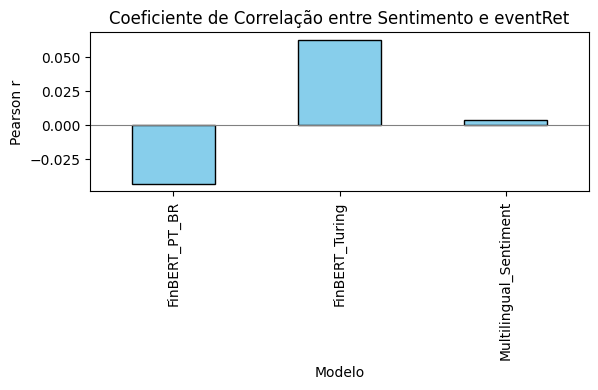

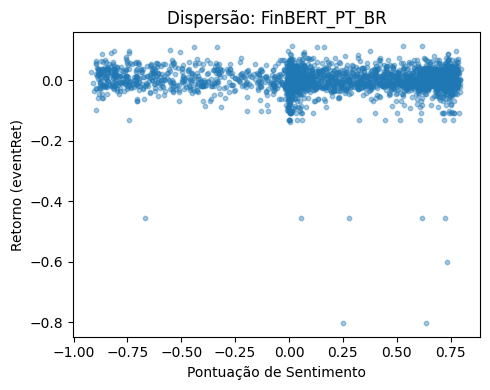

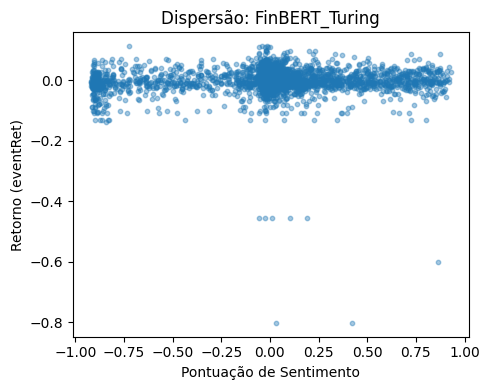

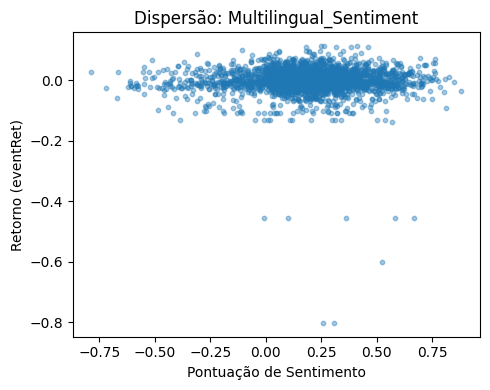

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. Cálculo de correlação e p-valor
resultados = []
for nome_modelo in modelos.keys():
    coluna = f"sentiment_{nome_modelo}"
    if coluna in data_df.columns:
        x = data_df[coluna]
        y = data_df["eventRet"]
        corr, p_valor = stats.pearsonr(x, y)
        resultados.append({
            "Modelo": nome_modelo,
            "Correlação": corr,
            "p-valor": p_valor
        })
        print(f"{nome_modelo}: correlação = {corr:.4f}, p-valor = {p_valor:.4g}")

# 2. DataFrame de resultados
corr_df = pd.DataFrame(resultados).set_index("Modelo")

# 3. Gráfico de barras
plt.figure(figsize=(6,4))
corr_df["Correlação"].plot(kind="bar", color="skyblue", edgecolor="black")
plt.axhline(0, color="gray", linewidth=0.8)
plt.title("Coeficiente de Correlação entre Sentimento e eventRet")
plt.ylabel("Pearson r")
plt.tight_layout()
plt.show()

# 4. Gráficos de dispersão
for nome_modelo in modelos.keys():
    coluna = f"sentiment_{nome_modelo}"
    if coluna in data_df.columns:
        plt.figure(figsize=(5,4))
        plt.scatter(data_df[coluna], data_df["eventRet"], alpha=0.4, s=10)
        plt.title(f"Dispersão: {nome_modelo}")
        plt.xlabel("Pontuação de Sentimento")
        plt.ylabel("Retorno (eventRet)")
        plt.tight_layout()
        plt.show()


Calculando escore contínuo para FinBERT_PT_BR...


  0%|          | 0/2742 [00:00<?, ?it/s]

Calculando escore contínuo para FinBERT_Turing...


  0%|          | 0/2742 [00:00<?, ?it/s]

FinBERT_PT_BR: correlação = -0.0463, p-valor = 0.01539
FinBERT_Turing: correlação = 0.0649, p-valor = 0.0006768


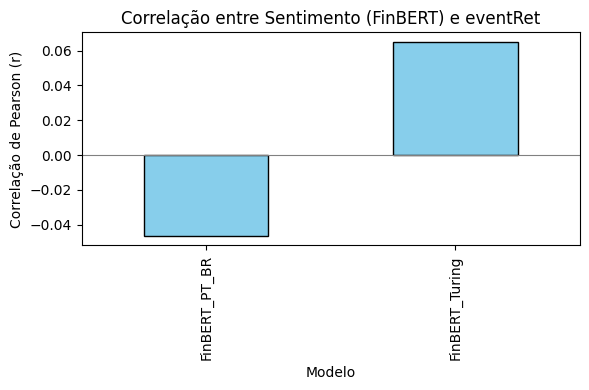

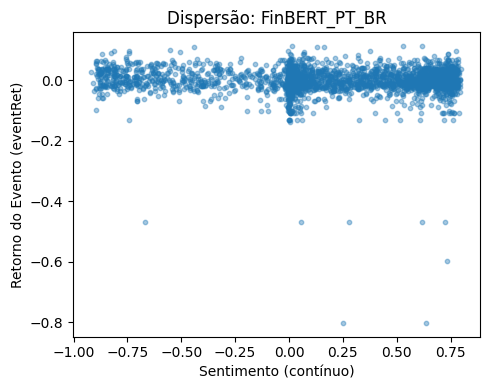

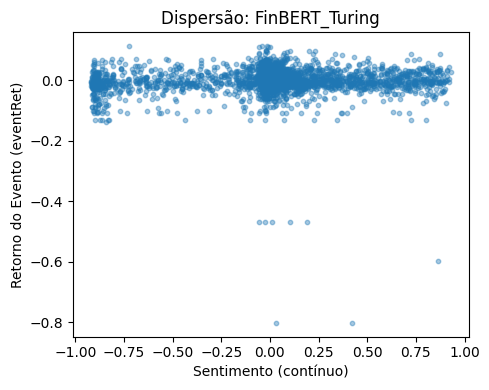

✅ Arquivo salvo com as atualizações: /content/Step4_Resultado_LSTM_CONTINUO.csv


In [126]:
# ====================================================
# AVALIAÇÃO DE MODELOS DE SENTIMENTO (ESCORE CONTÍNUO)
# ====================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt

# ----------------------------------------------------
# CONFIGURAÇÃO DO DISPOSITIVO E TOKEN
# ----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hf_token = os.environ.get("HF_TOKEN")

# ----------------------------------------------------
# FUNÇÃO DE POLARIDADE CONTÍNUA (POS - NEG)
# ----------------------------------------------------
def calcular_polaridade_continua(model_id: str, n_classes: int, textos: pd.Series) -> pd.Series:
    tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=hf_token)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, use_auth_token=hf_token).to(device)
    model.eval()

    def pontuar(texto: str) -> float:
        inputs = tokenizer(
            texto,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=512
        ).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()
        if n_classes == 3:
            return float(probs[2] - probs[0])  # POS - NEG
        elif n_classes == 2:
            return float(probs[1] - probs[0])  # POS - NEG (binário)
        return np.nan

    return textos.progress_apply(pontuar)

# ----------------------------------------------------
# CARREGAMENTO DO DATAFRAME
# ----------------------------------------------------
data_path = "/content/Step4_Resultado_LSTM_CONTINUO.csv"
assert os.path.exists(data_path), f"Arquivo não encontrado em: {data_path}"
data_df = pd.read_csv(data_path, sep="|")

# ----------------------------------------------------
# DEFINIÇÃO DOS MODELOS
# ----------------------------------------------------
modelos = {
    "FinBERT_PT_BR": {
        "repo": "lucas-leme/FinBERT-PT-BR",
        "n_classes": 3
    },
    "FinBERT_Turing": {
        "repo": "turing-usp/FinBertPTBR",
        "n_classes": 3
    }
}

# ----------------------------------------------------
# EXECUÇÃO DOS CÁLCULOS
# ----------------------------------------------------
tqdm.pandas()

for nome, cfg in modelos.items():
    coluna = f"sentiment_{nome}"
    if coluna not in data_df.columns:
        print(f"Calculando escore contínuo para {nome}...")
        data_df[coluna] = calcular_polaridade_continua(
            model_id=cfg["repo"],
            n_classes=cfg["n_classes"],
            textos=data_df["headline"]
        )

# ----------------------------------------------------
# CÁLCULO DE CORRELAÇÕES
# ----------------------------------------------------
resultados = []
for nome in modelos.keys():
    coluna = f"sentiment_{nome}"
    if coluna in data_df.columns:
        x = data_df[coluna].dropna()
        y = data_df["eventRet"].loc[x.index]
        corr, p_valor = stats.pearsonr(x, y)
        resultados.append({
            "Modelo": nome,
            "Correlação": corr,
            "p-valor": p_valor
        })
        print(f"{nome}: correlação = {corr:.4f}, p-valor = {p_valor:.4g}")

# ----------------------------------------------------
# GRÁFICO DE CORRELAÇÕES
# ----------------------------------------------------
if resultados:
    corr_df = pd.DataFrame(resultados).set_index("Modelo")
    plt.figure(figsize=(6, 4))
    corr_df["Correlação"].plot(kind="bar", color="skyblue", edgecolor="black")
    plt.axhline(0, color="gray", linewidth=0.8)
    plt.title("Correlação entre Sentimento (FinBERT) e eventRet")
    plt.ylabel("Correlação de Pearson (r)")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# GRÁFICOS DE DISPERSÃO
# ----------------------------------------------------
for nome in modelos.keys():
    coluna = f"sentiment_{nome}"
    if coluna in data_df.columns:
        plt.figure(figsize=(5, 4))
        plt.scatter(data_df[coluna], data_df["eventRet"], alpha=0.4, s=10)
        plt.title(f"Dispersão: {nome}")
        plt.xlabel("Sentimento (contínuo)")
        plt.ylabel("Retorno do Evento (eventRet)")
        plt.tight_layout()
        plt.show()

# ----------------------------------------------------
# SALVAMENTO DO RESULTADO ATUALIZADO
# ----------------------------------------------------
data_df.to_csv(data_path, sep="|", index=False)
print("✅ Arquivo salvo com as atualizações:", data_path)


In [127]:
print(data_df.columns.tolist())


['ticker', 'headline', 'date', 'eventRet', 'Close', 'sentiment_vader', 'sentiment_lex', 'sentiment_LSTM_cont', 'sentiment_FinBERT_PT_BR', 'sentiment_FinBERT_Turing']


<a id='4.2'></a>
## 4.2 – Análise de Sentimento com Classificadores Supervisionados e LSTM


## Construção de Pipeline com LSTM para Classificação Binária

Com base no conjunto consolidado contendo as variáveis `headline` e `eventRet`, foi construída uma *pipeline* de classificação binária utilizando redes neurais recorrentes do tipo **LSTM (Long Short-Term Memory)**.

### Preparação dos Dados

* A variável `eventRet` foi transformada em uma variável alvo binária:

  * Valores **≥ 0** foram rotulados como **1** (*retorno positivo*);
  * Valores **< 0** foram rotulados como **0** (*retorno negativo*).

* As manchetes textuais (`headline`) foram convertidas em vetores semânticos utilizando técnicas de *word embeddings*.

* Foram aplicadas as seguintes etapas de pré-processamento:

  * **Tokenização**: conversão das palavras em índices numéricos;
  * **Padding**: preenchimento das sequências para padronização do comprimento.

### Arquitetura do Modelo

O modelo foi estruturado com as seguintes camadas:

* `Embedding`:

  * Dimensão vetorial: **128**

* `LSTM`:

  * Unidades: **64**
  * Aplicação de **dropout** para regularização.

* Camada densa final:

  * Ativação: **sigmoide**
  * Finalidade: produção de probabilidade binária (0 ou 1)

### Estratégia de Treinamento

* O conjunto de dados foi dividido da seguinte forma:

  * **70%** para treino;
  * **30%** para teste.

* Foram utilizadas técnicas de:

  * **Validação cruzada**;
  * **Early stopping**, a fim de evitar *overfitting*.

### Resultados Obtidos

* **Acurácia no conjunto de treino**: **96,6%**
* **Acurácia no conjunto de teste**: **91,0%**
* **Correlação entre as predições e `eventRet`**: **0,446**
* **Matriz de confusão**: evidenciou equilíbrio na classificação entre as classes.

### Pós-Treinamento

Após o treinamento:

* O modelo foi aplicado ao **conjunto completo** de dados do intervalo de 01 de janeiro de 2022 a 31 de dezembro de 2024.
* As **predições** foram armazenadas para:

  * Análise quantitativa posterior;
  * Integração com **simulações de estratégias financeiras**.




In [32]:
!pip install --upgrade pip
!pip install keras tensorflow scikit-learn

Embedding manchetes:   0%|          | 0/2742 [00:33<?, ?manchete/s]


In [27]:
import numpy as np
import pandas as pd

# Parte 2.1 — Definição de sentiments_data
# logo após ter carregado data_df:
sentiments_data = data_df.copy()

# Agora a verificação prossegue sem NameError
if 'eventRet' not in sentiments_data.columns:
    if 'eventRet' in data_df.columns:
        data_df['date']        = pd.to_datetime(data_df['date'],        errors='coerce').dt.date
        sentiments_data['date']= pd.to_datetime(sentiments_data['date'],errors='coerce').dt.date
        sentiments_data = pd.merge(
            sentiments_data,
            data_df[['date','ticker','eventRet']],
            on=['date','ticker'],
            how='left'
        )
    else:
        raise KeyError("Coluna 'eventRet' não encontrada em sentiments_data nem em data_df")

In [28]:
# Remove registros sem manchete ou retorno
df_modelo = sentiments_data.dropna(subset=["headline", "eventRet"]).copy()

# Cria variável binária: 1 se eventRet ≥ 0, senão 0
df_modelo["sentiment"] = df_modelo["eventRet"].apply(lambda x: 1 if x >= 0 else 0)

# Exibe balanceamento
print("Distribuição dos rótulos:")
print(df_modelo["sentiment"].value_counts())

Distribuição dos rótulos:
sentiment
0    1411
1    1331
Name: count, dtype: int64


In [52]:
from tqdm import tqdm
import numpy as np

# ===============================================================
# GARANTIA: criação de df_modelo limpo
# ===============================================================
df_modelo = sentiments_data.dropna(subset=["headline", "eventRet"]).copy()
df_modelo["sentiment"] = (df_modelo["eventRet"] >= 0).astype(int)

# ===============================================================
# VETORIZAÇÃO DAS MANCHETES COM BARRA DE PROGRESSO
# ===============================================================

print("Gerando embeddings das manchetes... isso pode demorar.")

# Atenção: a função 'vetorizar_manchete' deve estar definida antes
embeddings = [
    vetorizar_manchete(str(texto))
    for texto in tqdm(
        df_modelo["headline"],
        desc="Embedding manchetes",
        unit="manchete"
    )
]

# Empilha os vetores resultantes em matriz numpy
X = np.vstack(embeddings)

# Define variável alvo binária
y = df_modelo["sentiment"].values


Gerando embeddings das manchetes... isso pode demorar.


Embedding manchetes: 100%|██████████| 2742/2742 [00:19<00:00, 138.10manchete/s]


In [135]:
#Parte 5. Tokenização, sequência e padding para LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Configura tokenizador
vocabulary_size = 20000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(df_modelo["headline"])

# Converte textos em sequências e aplica padding
sequences = tokenizer.texts_to_sequences(df_modelo["headline"])
X_seq = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')

# Divide em treino (70 %) e teste (30 %)
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(
    X_seq,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - loss: 0.0022 - mae: 0.0357 - val_loss: 0.0035 - val_mae: 0.0297
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0035 - val_mae: 0.0294
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - loss: 0.0023 - mae: 0.0301 - val_loss: 0.0035 - val_mae: 0.0294
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - loss: 0.0018 - mae: 0.0277 - val_loss: 0.0035 - val_mae: 0.0295
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - loss: 0.0018 - mae: 0.0279 - val_loss: 0.0035 - val_mae: 0.0294
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - loss: 0.0018 - mae: 0.0285 - val_loss: 0.0035 - val_mae: 0.0294


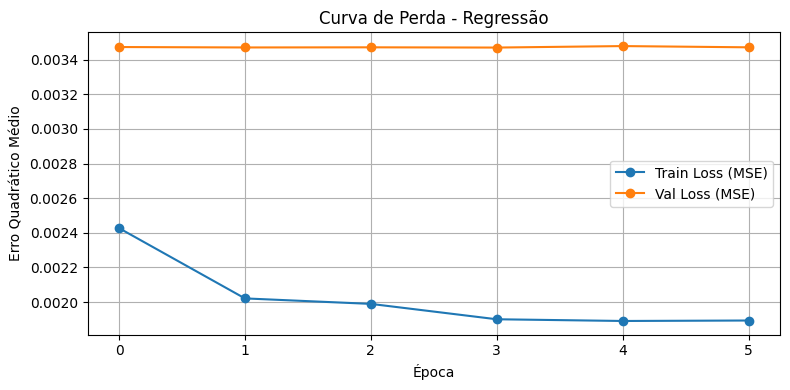

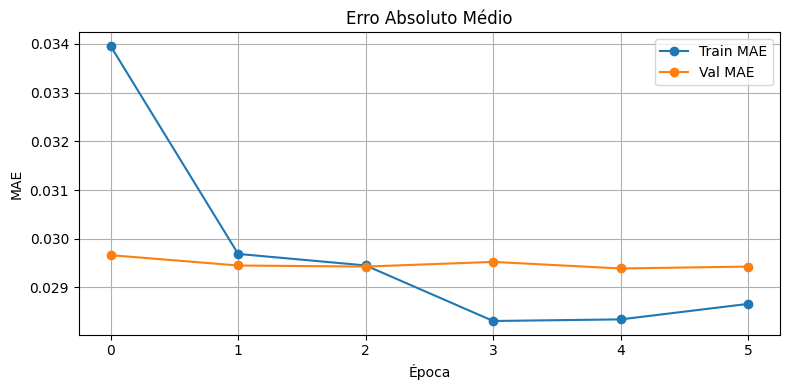

In [82]:
# 1. VARIÁVEIS DE AMBIENTE
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR


# 2. IMPORTS
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 3. LIMPEZA DE SESSÃO
K.clear_session()
tf.config.run_functions_eagerly(True)

# 4. PRECISÃO MISTA
mixed_precision.set_global_policy('mixed_float16')

# 5. HYPERPARÂMETROS
vocabulary_size = 10000
input_length    = 100
embed_dim       = 128
lstm_units      = 64
batch_size      = 32
epochs          = 10
val_split       = 0.2

# 6. CARREGAMENTO E PREPARO DOS DADOS
# df_modelo deve estar previamente carregado
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(df_modelo['headline'])
sequences = tokenizer.texts_to_sequences(df_modelo['headline'])
X_seq = pad_sequences(sequences, maxlen=input_length, padding='post', truncating='post')
y     = df_modelo['eventRet'].values  # << AGORA é regressão, valor contínuo

# Split treino+val / teste
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(
    X_seq, y, test_size=0.3, random_state=42
)

# Divisão interna treino / validação
num_train_val = X_train_val.shape[0]
n_val         = int(val_split * num_train_val)
X_val_LSTM    = X_train_val[:n_val]
y_val_LSTM    = y_train_val[:n_val]
X_train_LSTM  = X_train_val[n_val:]
y_train_LSTM  = y_train_val[n_val:]

# 7. PIPELINE tf.data
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_LSTM, y_train_LSTM))
      .shuffle(10000)
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val_LSTM, y_val_LSTM))
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

# 8. DEFINIÇÃO DO MODELO (saída contínua)
def create_model() -> Sequential:
    model = Sequential()
    model.add(Embedding(
        input_dim=tokenizer.num_words,
        output_dim=embed_dim,
        input_length=input_length
    ))
    model.add(LSTM(units=lstm_units, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear', dtype='float32'))  # << ESCALAR CONTÍNUO
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        loss='mse',                # << REGRESSÃO: erro quadrático médio
        optimizer=optimizer,
        metrics=['mae'],           # << erro absoluto médio
        run_eagerly=True
    )
    return model

model = create_model()

# 9. TREINAMENTO
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es],
    verbose=1
)

# 10. PLOTS
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],     'o-', label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], 'o-', label='Val Loss (MSE)')
plt.title('Curva de Perda - Regressão')
plt.xlabel('Época')
plt.ylabel('Erro Quadrático Médio')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig('loss_curve_regressao.png', dpi=300)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['mae'],     'o-', label='Train MAE')
plt.plot(history.history['val_mae'], 'o-', label='Val MAE')
plt.title('Erro Absoluto Médio(MAE)')
plt.xlabel('Época')
plt.ylabel('Erro Absoluto Médio')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig('mae_curve.png', dpi=300)
plt.show()


In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Parte 8: Avaliação Regressiva no Conjunto de Teste ---
print("\n=== Avaliação Regressiva: LSTM ===")

# Previsões contínuas
y_train_pred_cont = model.predict(X_train_LSTM, batch_size=batch_size).flatten()
y_test_pred_cont  = model.predict(X_test_LSTM,  batch_size=batch_size).flatten()

# Métricas
def imprimir_metricas_regressao(y_true, y_pred, nome_conjunto):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"\n>>> Conjunto: {nome_conjunto}")
    print(f"MAE     : {mae:.4f}")
    print(f"MSE     : {mse:.4f}")
    print(f"R²      : {r2:.4f}")

imprimir_metricas_regressao(y_train_LSTM, y_train_pred_cont, "Treino")
imprimir_metricas_regressao(y_test_LSTM,  y_test_pred_cont,  "Teste")

# --- Parte 9: Aplicação contínua ao DataFrame completo ---
data_df = sentiments_data.copy()

assert 'headline' in data_df.columns, "Coluna 'headline' não encontrada."

# Tokenização
seq_data   = tokenizer.texts_to_sequences(data_df["headline"].astype(str))
X_seq_data = pad_sequences(seq_data, maxlen=100, padding='post', truncating='post')

# Previsão contínua
y_sentiment_cont = model.predict(X_seq_data, batch_size=batch_size).flatten()

# Armazenamento e correlação
data_df["sentiment_LSTM_cont"] = y_sentiment_cont
if data_df["sentiment_LSTM_cont"].nunique() > 1:
    correlacao = data_df["eventRet"].corr(data_df["sentiment_LSTM_cont"])
    print(f"\nCorrelação entre sentimento contínuo (LSTM) e retorno: {correlacao:.4f}")
else:
    print("Aviso: escores contínuos idênticos — correlação indefinida.")

# Exportação
data_df.to_csv("/content/Step4_Resultado_LSTM_CONTINUO.csv", sep="|", index=False)
print("✅ Resultados contínuos salvos com sucesso.")


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),



=== Avaliação Regressiva: LSTM ===
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 859ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 859ms/step

>>> Conjunto: Treino
MAE     : 0.0267
MSE     : 0.0018
R²      : -0.0024

>>> Conjunto: Teste
MAE     : 0.0267
MSE     : 0.0023
R²      : -0.0001
86/86 ━━━━━━━━━━━━━━━━━━━━ 74s 866ms/step

Correlação entre sentimento contínuo (LSTM) e retorno: 0.0055
✅ Resultados contínuos salvos com sucesso.


In [134]:
print(data_df.columns.tolist())


['ticker', 'headline', 'date', 'eventRet', 'Close', 'sentiment_LSTM']


<a id='4.3'></a>
## 4.3 - Modelo não supervisionado baseado em léxico (VADER)

Modelo não supervisionado: Foi implementado um modelo de análise de sentimento baseado na técnica léxica VADER (Valence Aware Dictionary for Sentiment Reasoning), originalmente em inglês, adaptado para o contexto financeiro em português. Para isso, utilizou-se um dicionário de polaridades construído com apoio de modelos de linguagem generativos (ChatGPT-4 Mini e Gemini 2.5), contendo termos financeiros com valência atribuída manualmente e armazenada em formato JSON.
Os valores de polaridade foram normalizados na escala de -4 a +4 e integrados ao léxico original do VADER. Com isso, o modelo passou a reconhecer e ponderar termos específicos do domínio financeiro, aumentando sua sensibilidade semântica.

O VADER (Valence Aware Dictionary for Sentiment Reasoning) é um modelo pré-construído de análise de sentimentos incluído no pacote NLTK.

In [65]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pandas as pd
import matplotlib.pyplot as plt


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [116]:
# Inicializa o analisador de sentimento VADER
sia = SentimentIntensityAnalyzer()

# Aplica o modelo padrão VADER na coluna de manchetes
sentiments_data["sentiment_vader"] = sentiments_data["headline"].apply(
    lambda x: sia.polarity_scores(str(x))["compound"]
)

# Visualização
print(sentiments_data[["headline", "sentiment_lex"]].head())


                                            headline  sentiment_lex
0  Petrobras: vale a pena investir nas ações PETR...         0.0000
1  FUP se reúne com Petrobras (PETR3; PETR4) sobr...         0.0000
2  Taurus (TASA4) e Petrobras (PETR4) chamam aten...         0.0000
3  Petrobras (PETR4) avança em tecnologia de sepa...        -0.2960
4  FUP alerta para alta de casos de covid em plat...         0.7025


In [117]:
import json
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# 1. Inicializa VADER padrão
sia = SentimentIntensityAnalyzer()

# 2. Carrega o léxico customizado
with open('/content/sample_data/TERMOS.json', encoding='utf-8') as f:
    termos = json.load(f)

# 3. Converte para DataFrame e normaliza
df_lexico = pd.DataFrame(termos)
df_lexico = df_lexico.drop_duplicates(subset="termo")
df_lexico['termo'] = df_lexico['termo'].str.lower()

# 4. Verifica estrutura
required_cols = {'termo', 'polaridade'}
if not required_cols.issubset(df_lexico.columns):
    raise ValueError(f"O JSON deve conter as colunas: {required_cols}")

# 5. Dicionário original e escala
lexico_customizado = dict(zip(df_lexico['termo'], df_lexico['polaridade']))
max_pos = max([v for v in lexico_customizado.values() if v > 0], default=1)
min_neg = min([v for v in lexico_customizado.values() if v < 0], default=-1)

# 6. Reescalonamento para -4 a +4
lexico_ajustado = {
    termo: (valor / max_pos * 4 if valor > 0 else valor / abs(min_neg) * -4)
    for termo, valor in lexico_customizado.items()
}

# 7. Atualiza o VADER com os termos ajustados
sia.lexicon.update(lexico_ajustado)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [118]:
# Atualizar o léxico original do VADER
sia.lexicon.update(lexico_ajustado)


In [119]:
# Aplicando o VADER nas manchetes do dataset de notícias
sentiments_data['sentiment_lex'] = sentiments_data['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Visualização dos resultados
sentiments_data[['headline', 'sentiment_lex']].head()



headline  sentiment_lex
0  Petrobras: vale a pena investir nas ações PETR...         0.0000
1  FUP se reúne com Petrobras (PETR3; PETR4) sobr...         0.0000
2  Taurus (TASA4) e Petrobras (PETR4) chamam aten...         0.0000
3  Petrobras (PETR4) avança em tecnologia de sepa...        -0.2960
4  FUP alerta para alta de casos de covid em plat...         0.7025

* Um histograma da distribuição dos sentimentos VADER.
* A correlação (Pearson) entre o score de sentimento e o retorno de evento (`eventRet`).

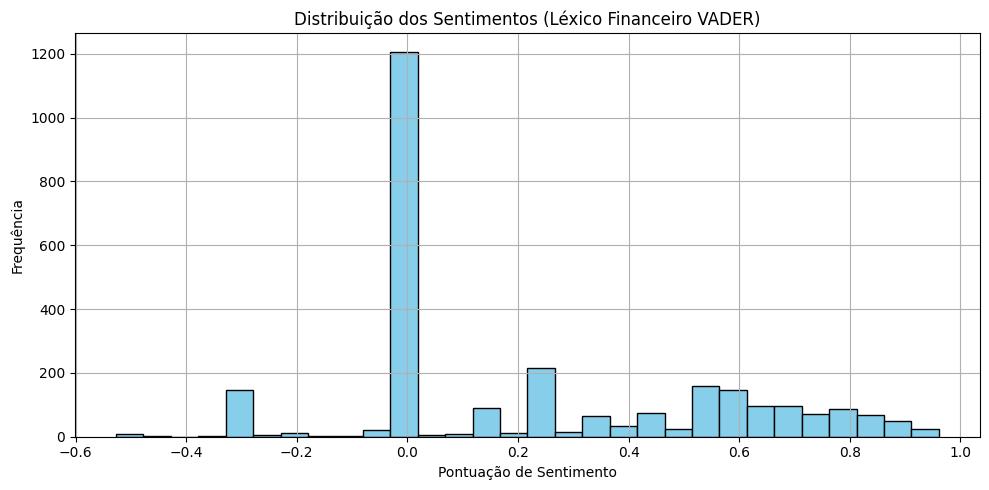

Correlação entre sentimento léxico e retorno: 0.0080


In [120]:
# Calcula o score de sentimento com VADER
def calcular_sentimento_vader(texto):
    return sia.polarity_scores(str(texto))['compound']

# Aplicação ao DataFrame principal
data_df['sentiment_lex'] = data_df['headline'].apply(calcular_sentimento_vader)

# Plotagem
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(data_df['sentiment_lex'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Sentimentos (Léxico Financeiro VADER)')
plt.xlabel('Pontuação de Sentimento')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlação
correlation = data_df['eventRet'].corr(data_df['sentiment_lex'])
print(f"Correlação entre sentimento léxico e retorno: {correlation:.4f}")


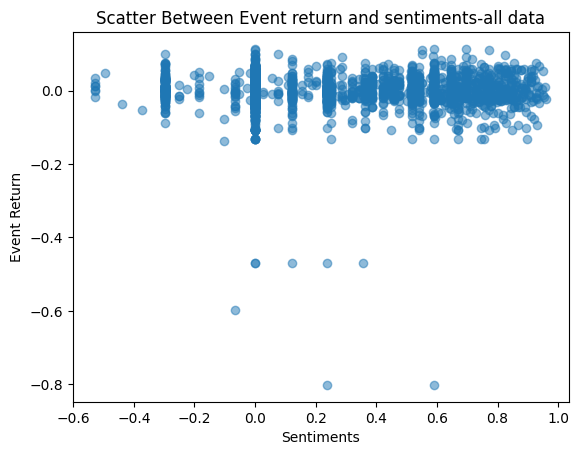

In [121]:
plt.scatter(data_df['sentiment_lex'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

<a id='4.4'></a>
## 4.4 Análise Exploratória e Comparação dos Modelos de Sentimento

In [122]:
print(data_df.columns.tolist())


['ticker', 'headline', 'date', 'eventRet', 'Close', 'sentiment_vader', 'sentiment_lex', 'sentiment_LSTM_cont', 'sentiment_FinBERT_PT_BR', 'sentiment_FinBERT_Turing']


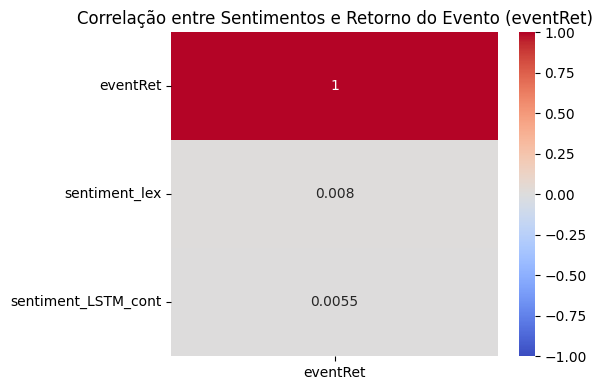

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregamento do DataFrame (ajuste o caminho se necessário)
data_df = pd.read_csv("/content/Step4_Resultado_LSTM_CONTINUO.csv", sep="|")

# Colunas de sentimento presentes
colunas_sentimentos = [
    'sentiment_lex',
    'sentiment_LSTM_cont',
    'sentiment_FinBERT_PT_BR',
    'sentiment_FinBERT_Turing',
    'eventRet'
]

# Filtra colunas disponíveis e remove ausentes
colunas_validas = [col for col in colunas_sentimentos if col in data_df.columns]
df_corr = data_df[colunas_validas].dropna()

# Matriz de correlação
correlacoes = df_corr.corr()

# Heatmap da correlação com retorno (eventRet)
plt.figure(figsize=(6, 4))
sns.heatmap(
    correlacoes[['eventRet']].sort_values(by='eventRet', ascending=False),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)
plt.title("Correlação entre Sentimentos e Retorno do Evento (eventRet)")
plt.tight_layout()
plt.show()


In [ ]:
# Análise de correlação por ticker
corr_data = []

for ticker in data_df['ticker'].dropna().unique():
    subset = data_df[data_df['ticker'] == ticker].dropna(subset=colunas_modelos)
    if subset.shape[0] >= 40:
        linha = [ticker]
        for col in colunas_modelos[:-1]:  # Exceto 'eventRet'
            linha.append(subset['eventRet'].corr(subset[col]))
        corr_data.append(linha)

# Criação do DataFrame
colunas_corr = ['ticker'] + [f'corr_{col}' for col in colunas_modelos[:-1]]
corr_df = pd.DataFrame(corr_data, columns=colunas_corr).set_index('ticker')
corr_df.head()


In [ ]:
# Exibe os 5 ativos com maior retorno absoluto para comparação
tickers_top = corr_df['corr_sentiment_LSTM'].abs().sort_values(ascending=False).head(5).index.tolist()

corr_df.loc[tickers_top].plot(kind='bar', figsize=(12, 6))
plt.title("Correlação por Ticker - Modelos de Sentimento")
plt.ylabel("Correlação com Retorno de Evento")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


<a id='5'></a>
# 5. Estratégia de Negociação Baseada em Sentimento

In [ ]:
!pip install backtrader yfinance --quiet
import yfinance as yf
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt


Os dados de sentimento podem ser usados ​​de diferentes maneiras para a estratégia de negociação. As pontuações de sentimento podem ser usadas como um sinal direcional e, idealmente, criar uma carteira long-short, comprando as ações com pontuação positiva e vendendo as ações com pontuação negativa. Os sentimentos também podem ser usados ​​como recursos adicionais, além de outros recursos (como ações correlacionadas e indicadores técnicos), em um modelo de aprendizado supervisionado para prever o preço ou elaborar uma estratégia de negociação.

Na estratégia de negociação neste estudo de caso, compramos e vendemos ações de acordo com os sentimentos atuais das ações:

* Compre uma ação quando a mudança na pontuação de sentimento (pontuação de sentimento atual - pontuação de sentimento anterior) for maior que 0,5 e venda uma ação quando a mudança na pontuação de sentimento for menor que -0,5.
* Além disso, verificamos a média móvel de 15 dias durante a compra e venda e compramos ou vendemos em uma unidade de 100.
Obviamente, pode haver muitas maneiras de criar uma estratégia de negociação baseada em sentimentos, variando o limite ou alterando o número de unidades com base no dinheiro inicial disponível.

Usamos sentimentos baseados em léxico para a estratégia de negociação

<a id='5.1'></a>
## 5.1.  Definição da Estratégia com Backtrader
Aqui, usamos o Backtrader, uma API baseada em Python para escrever e testar estratégias de negociação. O Backtrader permite que você se concentre em escrever estratégias de negociação, indicadores e analisadores reutilizáveis, em vez de ter que gastar tempo construindo infraestrutura. Temos uma estrutura conveniente para testar e escrever nossa estratégia de negociação. Usamos o código Quickstart na documentação (consulte https://www.backtrader.com/docu/quickstart/quickstart/ ) como base e o modificamos para incluir as pontuações de sentimento.

Implementamos uma estratégia simples para comprar se a pontuação de sentimento do dia anterior aumentar em 0,5 em relação ao último dia e vender se diminuir em 0,5.

A função a seguir contém duas classes:

Sentimento:
SentimentStrat: A função "next" desta classe implementa a estratégia de negociação real.

## 1. Coleta de Dados de Texto e Mercado
A primeira etapa consistiu na coleta automatizada de manchetes de notícias relacionadas a quatro ativos do mercado acionário brasileiro: VALE3.SA, PETR4.SA, ITUB4.SA e BBAS3.SA. A extração foi realizada por meio de requisições ao serviço RSS do Google News, utilizando expressões regulares parametrizadas com múltiplas formas de referência a cada ticker. O período considerado foi de 1º de janeiro de 2025 a 4 de maio de 2025, com segmentação mensal para respeitar limites de requisição e evitar sobrecarga nos servidores.

In [ ]:
# === IMPORTAÇÃO DE BIBLIOTECAS ===
import os
import json
import zipfile
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta

# === CONFIGURAÇÃO INICIAL ===
tickers_termos = {
    'VALE3.SA': ['VALE3', 'VALE3.SA', 'BVMF:VALE3'],
    'PETR4.SA': ['PETR4', 'PETR4.SA', 'BVMF:PETR4'],
    'ITUB4.SA': ['ITUB4', 'ITUB4.SA', 'BVMF:ITUB4'],
    'BBAS3.SA': ['BBAS3', 'BBAS3.SA', 'BVMF:BBAS3']
}

# Período de coleta
inicio = datetime.strptime('2025-01-01', '%Y-%m-%d')
fim    = datetime.strptime('2025-05-04', '%Y-%m-%d')

# Diretório de saída
data_suffix = datetime.now().strftime("%Y%m%d_%H%M%S")
saida_dir = f"noticias_json_{data_suffix}"
os.makedirs(saida_dir, exist_ok=True)

# === GERA INTERVALOS MENSAIS ENTRE DUAS DATAS ===
def gerar_periodos(start, end):
    periodos = []
    atual = start
    while atual < end:
        fim_mes = (atual + relativedelta(months=1)) - relativedelta(days=1)
        if fim_mes > end:
            fim_mes = end
        periodos.append((atual, fim_mes))
        atual = fim_mes + relativedelta(days=1)
    return periodos

# === COLETA DE NOTÍCIAS POR TICKER E PERÍODO ===
def coletar_noticias(ticker, termos, dt_ini, dt_fim):
    query = "(" + " OR ".join([f'"{t}"' if ' ' in t else t for t in termos]) + ")"
    url = (
        'https://news.google.com/rss/search'
        f'?q={query}+after:{dt_ini.strftime("%Y-%m-%d")}+before:{dt_fim.strftime("%Y-%m-%d")}'
        '&hl=pt-BR&gl=BR&ceid=BR:pt-419'
    )

    noticias = []
    try:
        resp = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}, timeout=10)
        soup = BeautifulSoup(resp.content, 'xml')

        for item in soup.find_all('item'):
            pub = datetime.strptime(item.pubDate.text, '%a, %d %b %Y %H:%M:%S %Z')
            if not (dt_ini <= pub <= dt_fim):
                continue
            titulo = item.title.text
            link = item.link.text
            resumo = BeautifulSoup(item.description.text, 'html.parser').get_text()
            if any(term.lower() in (titulo + link).lower() for term in termos):
                noticias.append({
                    'ticker': ticker,
                    'date': pub.strftime('%Y-%m-%d'),
                    'time': pub.strftime('%H:%M'),
                    'headline': titulo,
                    'summary': resumo,
                    'source': 'Google News RSS',
                    'url': link,
                    'language': 'pt',
                    'scraped_at': datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
                })
    except Exception as e:
        print(f"[ERRO] {ticker} ({dt_ini.date()} a {dt_fim.date()}): {e}")
    return noticias

# === EXECUÇÃO DA COLETA ===
periodos = gerar_periodos(inicio, fim)

for ticker, termos in tickers_termos.items():
    todas = []
    for dt_ini, dt_fim in periodos:
        todas += coletar_noticias(ticker, termos, dt_ini, dt_fim)

    if todas:
        path_json = os.path.join(saida_dir, f"{ticker}_noticias_{data_suffix}.json")
        with open(path_json, "w", encoding="utf-8") as f:
            json.dump(todas, f, indent=2, ensure_ascii=False)
        print(f"[✔️] {ticker}: {len(todas)} notícias salvas.")

# === COMPACTAÇÃO FINAL ===
zip_path = f"noticias_tickers_{data_suffix}.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for arq in os.listdir(saida_dir):
        zipf.write(os.path.join(saida_dir, arq), arcname=arq)

print(f"\n Arquivo ZIP final criado: {zip_path}")


Como resultado, foram coletadas:
* 367 manchetes para VALE3.SA
* 384 manchetes para PETR4.SA
* 245 manchetes para ITUB4.SA
* 301 manchetes para BBAS3.SA

Cada registro inclui data e hora da publicação, manchete, resumo da notícia, fonte, URL e idioma detectado. As notícias foram armazenadas em arquivos JSON e posteriormente estruturadas em um DataFrame padronizado para análise.


In [ ]:
from transformers import pipeline

def calcular_polaridade_continua(model_id, n_classes, textos):
    """
    Aplica modelo Hugging Face e transforma saída de classificação em valor contínuo entre -1 e +1.
    """
    # Define pipeline de sentimento com saída de probabilidade por classe
    classifier = pipeline("text-classification", model=model_id, return_all_scores=True, truncation=True)

    resultados = []

    for texto in tqdm(textos, desc=f"Analisando com {model_id}"):
        try:
            # Obtém as probabilidades para cada classe
            scores = classifier(str(texto))[0]

            # Mapeia classes padrão: assume 3 classes [NEG, NEU, POS]
            if n_classes == 3:
                probs = {s['label'].lower(): s['score'] for s in scores}

                # Normaliza nomes típicos de labels para consistência
                neg = next((v for k, v in probs.items() if 'neg' in k), 0)
                neu = next((v for k, v in probs.items() if 'neu' in k), 0)
                pos = next((v for k, v in probs.items() if 'pos' in k), 0)

                # Calcula escore contínuo: -1*neg + 0*neu + 1*pos = pos - neg
                score = pos - neg
            else:
                raise ValueError("Modelo com número de classes diferente de 3 não suportado.")

        except Exception as e:
            print(f"[ERRO interno] Texto: {texto[:50]}... -> {e}")
            score = 0.0  # fallback neutro

        resultados.append(score)

    return resultados


In [ ]:
import os
import json
import pandas as pd
from zipfile import ZipFile

# Caminho para o arquivo ZIP gerado anteriormente
zip_path = "/content/noticias_tickers_20250504_203905.zip"
extract_path = "/content/noticias_2025"

# Extrai o conteúdo do ZIP
os.makedirs(extract_path, exist_ok=True)
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Consolida todos os arquivos JSON em um único DataFrame
noticias_lista = []
for arquivo in os.listdir(extract_path):
    if arquivo.endswith(".json"):
        caminho = os.path.join(extract_path, arquivo)
        with open(caminho, encoding="utf-8") as f:
            dados = json.load(f)
            noticias_lista.extend(dados)

# Cria DataFrame único com as notícias
df_noticias = pd.DataFrame(noticias_lista)
df_noticias['date'] = pd.to_datetime(df_noticias['date']).dt.date  # normaliza data
df_noticias = df_noticias[['date', 'ticker', 'headline']].dropna()

# Visualização
print(f"[✔️] Total de registros carregados: {len(df_noticias)}")
df_noticias.head()


Carregamento e Consolidação dos Arquivos de Notícias

Aplicar os Modelos de Sentimento (Já Treinados)

## 2. Classificação de Sentimento com Modelos NLP


As manchetes foram submetidas aos cinco modelos de análise de sentimento descritos anteriormente:

LSTM supervisionado (baseado em retorno de evento)

VADER com léxico financeiro em português

FinBERT_PT_BR

FinBERT_Turing

Multilingual_Sentiment

Todos os modelos foram aplicados com saída contínua no intervalo [–1, +1], por meio de transformação dos logits com softmax (nos modelos Hugging Face) ou diretamente por cálculo de escore composto (no caso do VADER).

In [ ]:
# === GARANTE QUE AS COLUNAS ORIGINAIS NÃO SERÃO PERDIDAS ===
colunas_originais = df_noticias.columns.tolist()

# === MODELO LSTM ===
print(" Aplicando modelo LSTM...")
seq = tokenizer.texts_to_sequences(df_noticias['headline'].astype(str))
X_seq = pad_sequences(seq, maxlen=50)
df_noticias['sentiment_LSTM_raw'] = model_LSTM.predict(X_seq, verbose=0).flatten()
df_noticias['sentiment_LSTM'] = (2 * df_noticias['sentiment_LSTM_raw']) - 1  # Normaliza para [-1, 1]

# === MODELO VADER (LÉXICO FINANCEIRO) ===
print(" Aplicando modelo VADER com léxico financeiro...")
df_noticias['sentiment_lex'] = df_noticias['headline'].apply(
    lambda x: sia.polarity_scores(str(x))['compound']
)

# === MODELOS HUGGING FACE COM TRATAMENTO DE INVERSÃO ===
modelos_hf = {
    "FinBERT_PT_BR": {
        "repo": "lucas-leme/FinBERT-PT-BR",
        "n_classes": 3,
        "inverter_escala": True  # ← Inverter resultado
    },
    "FinBERT_Turing": {
        "repo": "turing-usp/FinBertPTBR",
        "n_classes": 3,
        "inverter_escala": True  # ← Inverter resultado
    },
    "Multilingual_Sentiment": {
        "repo": "tabularisai/multilingual-sentiment-analysis",
        "n_classes": 3,
        "inverter_escala": False
    }
}

for nome_modelo, config in modelos_hf.items():
    print(f" Aplicando {nome_modelo}...")
    try:
        coluna_saida = f"sentiment_{nome_modelo}"
        valores = calcular_polaridade_continua(
            model_id=config["repo"],
            n_classes=config["n_classes"],
            textos=df_noticias["headline"]
        )

        # Inversão se necessário
        if config.get("inverter_escala", False):
            valores = [-1 * v for v in valores]

        df_noticias[coluna_saida] = valores

    except Exception as e:
        print(f"[ERRO] {nome_modelo}: {e}")

# === VERIFICAÇÃO FINAL ===
print("Colunas após aplicação de todos os modelos:")
print(df_noticias.columns.tolist())


Agregação Diária por Ticker

In [ ]:

# ✅ Validação: imprime colunas disponíveis
print("Colunas disponíveis em df_noticias:", df_noticias.columns.tolist())


In [ ]:
# Agrupamento por data e ticker, ordenando por ordem cronológica para manter consistência
agrupado = df_noticias.sort_values(['date', 'ticker']).groupby(['date', 'ticker'])

# Agregação dos sentimentos por média, e preservação da primeira notícia e resumo
df_diario = agrupado.agg({
    'headline': 'first',
    'sentiment_lex': 'mean',
    'sentiment_LSTM': 'mean',
    'sentiment_FinBERT_PT_BR': 'mean',
    'sentiment_FinBERT_Turing': 'mean',
    'sentiment_Multilingual_Sentiment': 'mean',
}).reset_index()

# Visualização e confirmação
print(f"[✔️] df_diario gerado com {df_diario.shape[0]} linhas e {df_diario.shape[1]} colunas.")
display(df_diario.head())

In [ ]:
import pandas as pd
from IPython.display import display, Markdown
import seaborn as sns

# 1. Verifica estrutura do DataFrame
colunas = df_diario.columns.tolist()
tickers = df_diario['ticker'].unique()
data_inicio = df_diario['date'].min()
data_fim = df_diario['date'].max()

# 2. Calcula estatísticas (mínimo, máximo e média) por modelo
estatisticas = df_diario[[
    'sentiment_lex',
    'sentiment_LSTM',
    'sentiment_FinBERT_PT_BR',
    'sentiment_FinBERT_Turing',
    'sentiment_Multilingual_Sentiment'
]].describe().loc[['min', 'max', 'mean']].round(3)

# 3. Mostra resumo textual
display(Markdown(f"""
### 📄 Estrutura do DataFrame

**Colunas presentes:**
`{', '.join(colunas)}`

**Tickers únicos encontrados:**
{', '.join(tickers)}

**Intervalo de datas disponíveis:**
De **{data_inicio}** até **{data_fim}**
"""))

# 4. Mostra estatísticas com formatação
cmap = sns.light_palette("green", as_cmap=True)

display(
    estatisticas.style
        .background_gradient(cmap=cmap)
        .format(precision=3)
        .set_caption("📊 Estatísticas dos Sentimentos (mín, máx, média)")
        .set_properties(**{'font-size': '10pt', 'width': '80px'})
)


In [ ]:
from IPython.display import display, HTML

# Lista de tickers
tickers = ['BBAS3.SA', 'ITUB4.SA', 'PETR4.SA', 'VALE3.SA']

# Colunas de sentimento
colunas_sentimentos = [
    'sentiment_lex',
    'sentiment_LSTM',
    'sentiment_FinBERT_PT_BR',
    'sentiment_FinBERT_Turing',
    'sentiment_Multilingual_Sentiment'
]

# Armazena as tabelas formatadas
html_tabelas = []

for ticker in tickers:
    df_ticker = df_diario[df_diario['ticker'] == ticker]

    if len(df_ticker) < 2:
        continue

    matriz_corr = df_ticker[colunas_sentimentos].corr(method='pearson')

    styler = matriz_corr.style\
        .background_gradient(cmap='coolwarm')\
        .format(precision=2)\
        .set_caption(f"<b>{ticker}</b>")\
        .set_properties(**{
            'font-size': '9pt',
            'width': '60px'
        })

    html_tabelas.append(styler.to_html())

# Cria layout horizontal com CSS flexbox
html_final = f"""
<div style="display: flex; gap: 20px;">
    {''.join(f'<div>{t}</div>' for t in html_tabelas)}
</div>
"""

# Exibe todas as matrizes lado a lado
display(HTML(html_final))


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")  # fundo com grid discreto
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'lines.linewidth': 2,
    'grid.alpha': 0.6,
    'grid.linestyle': '--',
    'figure.figsize': (14, 6)
})

# Ativo em foco
ticker_exemplo = 'VALE3.SA'
df_exemplo = df_diario[df_diario['ticker'] == ticker_exemplo].copy()

# Média móvel para suavização dos dados
window = 5
for col in [
    'sentiment_lex', 'sentiment_LSTM', 'sentiment_FinBERT_PT_BR',
    'sentiment_FinBERT_Turing', 'sentiment_Multilingual_Sentiment'
]:
    df_exemplo[col + '_smoothed'] = df_exemplo[col].rolling(window=window, center=True).mean()

# Cores elegantes e consistentes
cores = {
    'sentiment_lex_smoothed': '#1f77b4',
    'sentiment_LSTM_smoothed': '#ff7f0e',
    'sentiment_FinBERT_PT_BR_smoothed': '#2ca02c',
    'sentiment_FinBERT_Turing_smoothed': '#d62728',
    'sentiment_Multilingual_Sentiment_smoothed': '#9467bd'
}

# Criação da figura
fig, ax = plt.subplots()

# Plotagem das curvas suavizadas
for col, cor in cores.items():
    ax.plot(df_exemplo['date'], df_exemplo[col], label=col.replace('_smoothed', ''), color=cor)

# Ajustes finais no layout
ax.set_title(f"Evolução dos Sentimentos – {ticker_exemplo}")
ax.set_xlabel("Data")
ax.set_ylabel("Sentimento Médio Diário")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()



## Etapa 2: Execução da Estratégia Individual por Modelo de Sentimento

### Tentei incluir a estratégia de média móvel, mas não consegui.

Será realizada a simulação da estratégia para **cada coluna de sentimento** (`sentiment_lex`, `sentiment_LSTM`, etc.) **individualmente**. Como o intervalo de tempo da análise é curto (`2025-01-01` a `2025-05-04` ≈ 4 meses), utilizar **apenas a média móvel de 15 dias (SMA15)** pode limitar a responsividade da estratégia. Adotamos então variação da estratégia com múltiplas médias móveis:

| Nome      | Período | Finalidade                              |
| --------- | ------- | --------------------------------------- |
| **SMA5**  | 5 dias  | Curto prazo, mais sensível a reversões  |
| **SMA10** | 10 dias | Curto/médio prazo, menos ruído que SMA5 |
| **SMA15** | 15 dias | Referência padrão de tendência          |
| **SMA20** | 20 dias | Média mais "suave", evita sinais falsos |

---

### Estratégia por Média Móvel

Para cada uma dessas médias móveis, aplicaremos:

#### **Critério de Compra**

* > Compra: Δsentimento > 0.5 e Preço atual > média móvel (SMAx)
* > Venda: Δsentimento < -0.5 e Preço atual < média móvel (SMAx)


### Execuções planejadas

Para **cada modelo de sentimento** (`sentiment_lex`, `sentiment_LSTM`, etc.), a estratégia será executada **para cada média móvel separadamente**, totalizando:

```
5 modelos × 4 médias móveis = 20 simulações
```

Cada simulação terá:

* Valor inicial: R\$ 100.000
* Lote fixo: 100 ações
* Período: 2025-01-01 a 2025-05-04


#Coleta dos preços históricos com médias móveis

Código para coletar os preços históricos de fechamento via `yfinance`, calcular as médias móveis e deixar tudo pronto para cruzar com o DataFrame de sentimentos por ticker e data:

In [ ]:
# IMPORTAÇÃO DE BIBLIOTECAS

import yfinance as yf
import pandas as pd
import os

from google.colab import data_table
data_table.enable_dataframe_formatter()


# PARÂMETROS DE CONFIGURAÇÃO

# Tickers brasileiros analisados
tickers = ['VALE3.SA', 'PETR4.SA', 'ITUB4.SA', 'BBAS3.SA']

# Intervalo de datas da análise
start = '2025-01-01'
end   = '2025-05-04'

# Diretório de saída
os.makedirs("data", exist_ok=True)

# MAPA DOS DIAS DA SEMANA EM PORTUGUÊS

dias_semana_pt = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

# COLETA DOS DADOS HISTÓRICOS COM TRATAMENTO

dados_completos = []

for ticker in tickers:
    print(f" Coletando dados de: {ticker}")
    try:
        ticker_yf = yf.Ticker(ticker)
        dados = ticker_yf.history(start=start, end=end)

        # Validação: ignorar tickers com dados vazios
        if dados.empty:
            print(f" Dados indisponíveis para {ticker}, ignorado.")
            continue

        # Resetar índice (Date como coluna)
        dados = dados.reset_index()

        # Garantir consistência de datas e tipos
        dados['Date'] = pd.to_datetime(dados['Date'], errors='coerce')
        dados = dados.dropna(subset=['Date'])

        # Formatação de colunas auxiliares
        dados['Data'] = dados['Date'].dt.strftime('%Y-%m-%d')
        dados['Hora'] = dados['Date'].dt.strftime('%H:%M:%S')
        dados['Dia_da_semana'] = dados['Date'].dt.day_name().map(dias_semana_pt)
        dados['Ticker'] = ticker

        # Seleção e ordenação de colunas
        dados_formatado = dados[[
            'Data', 'Dia_da_semana', 'Open', 'High', 'Low', 'Close',
            'Volume', 'Dividends', 'Stock Splits', 'Ticker'
        ]]

        dados_completos.append(dados_formatado)
        print(f" {ticker}: {dados_formatado.shape[0]} registros coletados.")

    except Exception as e:
        print(f" Erro ao coletar dados de {ticker}: {e}")


# CONSOLIDAÇÃO E SALVAMENTO DOS RESULTADOS

if dados_completos:
    df_final = pd.concat(dados_completos, ignore_index=True)
    df_final = df_final.sort_values(by=['Ticker', 'Data'])

    # Caminhos de saída
    caminho_csv   = "data/ReturnData_2025.csv"
    caminho_excel = "data/ReturnData_2025.xlsx"

    # Salvamento em formatos compatíveis
    df_final.to_csv(caminho_csv, sep='|', index=False)
    df_final.to_excel(caminho_excel, index=False, engine='openpyxl')

    print(f"\n Arquivos salvos com sucesso:")
    print(f"  - CSV: {caminho_csv}")
    print(f"  - Excel: {caminho_excel}")

    # Exibição interativa no Colab
    display(data_table.DataTable(df_final))
else:
    print(" Nenhum dado foi coletado com sucesso.")

# Cálculo das Médias Móveis

Abaixo está o código para adicionar colunas de médias móveis ao DataFrame `df_final`, para cada `Ticker` individualmente, usando os valores da coluna `Close`.

Médias móveis incluídas:

* SMA5: 5 dias (curto prazo)
* SMA10: 10 dias
* SMA15: 15 dias (padrão da estratégia)
* SMA20: 20 dias (suavização maior)



In [ ]:
# CÁLCULO DAS MÉDIAS MÓVEIS POR TICKER

# Cópia de segurança do DataFrame original
df_mm = df_final.copy()

# Converte a coluna 'Data' para datetime (caso necessário)
df_mm['Data'] = pd.to_datetime(df_mm['Data'], format='%Y-%m-%d', errors='coerce')

# Ordena corretamente
df_mm = df_mm.sort_values(by=['Ticker', 'Data'])

# Cálculo das médias móveis por ticker
for window in [5, 10, 15, 20]:
    nome_coluna = f'SMA{window}'
    df_mm[nome_coluna] = (
        df_mm.groupby('Ticker')['Close']
        .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    )

# Verificação
print(f" Médias móveis calculadas com sucesso para {df_mm['Ticker'].nunique()} ativos.")
display(data_table.DataTable(df_mm.tail(10)))


In [ ]:
print("Colunas disponíveis em df_diario:")
print(df_diario.columns.tolist())

In [ ]:
print("Colunas disponíveis em dados_formatado:")
print(dados_formatado.columns.tolist())

In [ ]:
import pandas as pd
from datetime import date, timedelta

# --- 1. Geração de todas as datas no intervalo ---
inicio = date(2025, 1, 1)
fim = date(2025, 5, 4)
todas_datas = pd.date_range(start=inicio, end=fim, freq='D').date

# --- 2. Tickers disponíveis ---
tickers = dados_formatado['ticker'].unique().tolist()

# --- 3. Produto cartesiano: todos os dias para cada ticker ---
base_completa = pd.MultiIndex.from_product(
    [todas_datas, tickers],
    names=['date', 'ticker']
).to_frame(index=False)

# --- 4. Junção com base de preços ---
df_precos = dados_formatado.copy()
df_precos['date'] = pd.to_datetime(df_precos['date']).dt.date
merged_1 = pd.merge(base_completa, df_precos, how='left', on=['date', 'ticker'])

# --- 5. Junção com base de sentimentos ---
df_diario['date'] = pd.to_datetime(df_diario['date']).dt.date
merged_2 = pd.merge(merged_1, df_diario, how='left', on=['date', 'ticker'])

# --- 6. Atualização de Dia da Semana com nomes em português ---
dias_pt = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
merged_2['Dia_da_semana'] = pd.to_datetime(merged_2['date']).dt.day_name().map(dias_pt)

# --- 7. Organização final ---
merged_2 = merged_2.sort_values(by=['ticker', 'date']).reset_index(drop=True)

# --- 8. Estatísticas ---
print("✅ Base unificada (preço + sentimento) criada com todas as datas.")
print(f"Total de linhas: {merged_2.shape[0]}")
print(f"Período coberto: {merged_2['date'].min()} até {merged_2['date'].max()}")
print(f"Colunas disponíveis: {merged_2.columns.tolist()}")

# --- 9. Visualização ---
display(merged_2.head(5))

# --- 10. Salvamento final ---
merged_2.to_csv("data/BaseCompleta_2025.csv", sep='|', index=False)
merged_2.to_excel("data/BaseCompleta_2025.xlsx", index=False)


In [ ]:
import backtrader as bt

class SentimentStrat(bt.Strategy):
    params = (
        ('sentiment_dict', None),
        ('sma_col', 'SMA15')
    )

    def __init__(self):
        self.order = None
        self.dataclose = self.datas[0].close
        self.dates = self.datas[0].datetime

    def next(self):
        current_date = bt.num2date(self.dates[0]).date()
        sentiment_today = self.params.sentiment_dict.get(current_date)
        sentiment_yesterday = self.params.sentiment_dict.get(current_date - pd.Timedelta(days=1))

        if sentiment_today is None or sentiment_yesterday is None:
            return  # Não há dado de sentimento suficiente

        delta_sentiment = sentiment_today - sentiment_yesterday
        sma_value = getattr(self.datas[0], self.params.sma_col, None)[0]

        if sma_value is None:
            return  # Não há SMA suficiente

        if not self.position:
            if delta_sentiment > 0.5 and self.dataclose[0] > sma_value:
                self.order = self.buy()
        else:
            if delta_sentiment < -0.5 and self.dataclose[0] < sma_value:
                self.order = self.sell()


In [ ]:
import yfinance as yf
import backtrader as bt
import pandas as pd


class SentimentStrat(bt.Strategy):
    params = (
        ('sentiment_dict', {}),
        ('sma_col', 'sma'),
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.sentiment = self.p.sentiment_dict
        self.sma = self.datas[0].sma

    def next(self):
        data_atual = self.datas[0].datetime.date(0)

        if data_atual not in self.sentiment:
            return

        sentimento_hoje = self.sentiment.get(data_atual, 0)
        sentimento_ontem = self.sentiment.get(
            data_atual - pd.Timedelta(days=1), 0)
        delta_sent = sentimento_hoje - sentimento_ontem

        if self.order:
            return

        if not self.position:
            if delta_sent > 0.5 and self.dataclose[0] > self.sma[0]:
                self.order = self.buy(size=100)
        else:
            if delta_sent < -0.5 and self.dataclose[0] < self.sma[0]:
                self.order = self.sell(size=100)


class PandasSentiment(bt.feeds.PandasData):
    lines = ('sma',)
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', -1),
        ('sma', -1),  # -1 = procura uma coluna com esse nome
    )


def run_strategy(ticker, start, end, sentiment_series, sma_col='SMA15', plot=False):
    print(f"Executando estratégia para: {ticker} | SMA: {sma_col}")

    janela = int(sma_col.replace('SMA', ''))

    df_price = yf.download(ticker, start=start, end=end)
    if df_price.empty:
        print(f"[ERRO] Dados de preço vazios para {ticker}.")
        return None

   # **Change 1:** Check if columns is MultiIndex, and if so, convert to single level
    if isinstance(df_price.columns, pd.MultiIndex):
        df_price.columns = df_price.columns.get_level_values(0)

    df_price['sma'] = df_price['Close'].rolling(window=janela).mean()
    df_price = df_price[['Open', 'High', 'Low', 'Close', 'Volume', 'sma']].dropna()
    df_price.index.name = 'datetime'

    # **Change 2 (removed):** Removed converting column names to strings as it's unnecessary after flattening the MultiIndex

    data_bt = PandasSentiment(dataname=df_price)

    cerebro = bt.Cerebro()
    cerebro.adddata(data_bt)
    cerebro.addstrategy(SentimentStrat, sentiment_dict=sentiment_series)
    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    valor_inicial = cerebro.broker.getvalue()
    cerebro.run()
    valor_final = cerebro.broker.getvalue()

    if plot:
        cerebro.plot(volume=False, iplot=False)

    return {
        'ticker': ticker,
        'sma': sma_col,
        'valor_inicial': valor_inicial,
        'valor_final': valor_final,
        'lucro': valor_final - valor_inicial,
        'lucro_pct': (valor_final - valor_inicial) / valor_inicial * 100
    }


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from collections import defaultdict

# === PARÂMETROS ===
ticker = 'VALE3.SA'
modelos_sentimento = [
    'sentiment_lex',
    'sentiment_LSTM',
    'sentiment_FinBERT_PT_BR',
    'sentiment_FinBERT_Turing',
    'sentiment_Multilingual_Sentiment',
    'sentiment_random'  # modelo de benchmark aleatório
]
capital_inicial = 100_000
taxa_b3 = 0.0003  # 0,03%

# === PERÍODO ===
datas_validas = df_diario[df_diario['ticker'] == ticker]['date'].dropna()
inicio = pd.to_datetime(datas_validas.min()).strftime('%Y-%m-%d')
fim    = pd.to_datetime(datas_validas.max()).strftime('%Y-%m-%d')
print(f"📅 Período: {inicio} a {fim}")

# === PREÇOS ===
df_price = yf.download(ticker, start=inicio, end=fim, progress=False)
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_price.columns]
df_price = df_price.reset_index()
df_price['date'] = pd.to_datetime(df_price['Date']).dt.date
col_close = f'Close_{ticker}' if f'Close_{ticker}' in df_price.columns else 'Close'
df_price['close'] = df_price[col_close]

# === DIRETÓRIO ===
os.makedirs("data", exist_ok=True)

# === RESULTADOS GERAIS ===
resultados = []
curvas = {}

for modelo_sent in modelos_sentimento:
    print(f"\n▶️ Modelo proporcional: {modelo_sent}")

    if modelo_sent == 'sentiment_random':
        # Gera valores aleatórios entre -1 e 1
        df_sent = pd.DataFrame({
            'date': df_price['date'],
            'sentiment_random': np.random.uniform(-1, 1, size=len(df_price))
        })
    else:
        df_sent = df_diario[df_diario['ticker'] == ticker][['date', modelo_sent]].dropna()
        if df_sent.empty:
            print(f"⚠️ Sem dados para {modelo_sent}. Pulando.")
            continue

    df_sent['date'] = pd.to_datetime(df_sent['date']).dt.date
    sentimento_dict = df_sent.set_index('date')[modelo_sent].to_dict()

    capital = capital_inicial
    posicao = 0
    decisoes = []
    operacoes = 0
    acertos = 0
    taxas_B3 = 0.0
    IR_pago = 0.0
    historico_valor = []

    vendas_mes = defaultdict(float)
    lucro_mes = defaultdict(float)
    prejuizo_acumulado = 0.0
    preco_medio = 0.0

    for _, row in df_price.iterrows():
        data = pd.to_datetime(row['date']).date()
        preco = row['close']
        sentimento = sentimento_dict.get(data, 0.0)
        acao = "MANTER"
        quantidade = 0
        taxa = 0.0

        # --- COMPRA ---
        if sentimento > 0:
            valor_para_compra = capital * sentimento
            quantidade = int(valor_para_compra / preco)
            if quantidade > 0:
                valor_op = quantidade * preco
                taxa = valor_op * taxa_b3
                custo_total = valor_op + taxa
                if capital >= custo_total:
                    preco_medio = ((preco_medio * posicao) + valor_op) / (posicao + quantidade) if posicao > 0 else preco
                    capital -= custo_total
                    posicao += quantidade
                    taxas_B3 += taxa
                    operacoes += 1
                    acao = f"COMPRA {quantidade}"

        # --- VENDA ---
        elif sentimento < 0 and posicao > 0:
            quantidade = int(posicao * abs(sentimento))
            if quantidade > 0:
                valor_op = quantidade * preco
                taxa = valor_op * taxa_b3
                receita_liquida = valor_op - taxa
                capital += receita_liquida
                posicao -= quantidade
                taxas_B3 += taxa
                operacoes += 1
                acao = f"VENDA {quantidade}"

                lucro_real = (preco - preco_medio) * quantidade
                mes = data.strftime('%Y-%m')
                vendas_mes[mes] += valor_op

                if lucro_real > 0:
                    acertos += 1
                    lucro_mes[mes] += lucro_real
                else:
                    prejuizo_acumulado += abs(lucro_real)

        valor_total = capital + posicao * preco
        historico_valor.append(valor_total)

        decisoes.append({
            'date': data,
            'modelo': modelo_sent,
            'sentimento': sentimento,
            'close': preco,
            'acao': acao,
            'quantidade': quantidade,
            'posicao': posicao,
            'capital_em_dinheiro': capital,
            'capital_total_estimado': valor_total,
            'taxas_B3': taxas_B3
        })

    # === CÁLCULO DO IR ===
    for mes in lucro_mes:
        lucro = lucro_mes[mes] - prejuizo_acumulado
        if lucro <= 0:
            prejuizo_acumulado = abs(lucro)
            continue
        if vendas_mes[mes] > 20_000:
            IR_pago += lucro * 0.15
            prejuizo_acumulado = 0.0

    # === MÉTRICAS ===
    lucro_bruto = valor_total - capital_inicial
    lucro_liquido = lucro_bruto - IR_pago
    lucro_pct = (lucro_liquido / capital_inicial) * 100
    retorno_diario = pd.Series(historico_valor).pct_change().dropna()
    sharpe = retorno_diario.mean() / retorno_diario.std() * np.sqrt(252) if len(retorno_diario) > 1 else 0
    max_drawdown = (pd.Series(historico_valor).cummax() - pd.Series(historico_valor)).max()
    taxa_acerto = acertos / operacoes * 100 if operacoes > 0 else 0

    curvas[modelo_sent] = pd.DataFrame(decisoes)

    resultados.append({
        'modelo': modelo_sent,
        'valor_final': valor_total,
        'lucro_bruto': lucro_bruto,
        'IR_pago': IR_pago,
        'lucro_liquido': lucro_liquido,
        'lucro_pct': lucro_pct,
        'n_operacoes': operacoes,
        'taxa_acerto_pct': taxa_acerto,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'taxas_B3': taxas_B3
    })

# === RESUMO ===
df_resultados = pd.DataFrame(resultados).sort_values(by='lucro_pct', ascending=False)
print("\n📊 COMPARATIVO COM MODELO ALEATÓRIO (Random Benchmark):")
display(df_resultados)

# === PLOTAGEM ===
plt.figure(figsize=(14, 7))
for modelo, df in curvas.items():
    df['date'] = pd.to_datetime(df['date'])
    lucro = df_resultados[df_resultados['modelo'] == modelo]['lucro_pct'].values[0]
    plt.plot(df['date'], df['capital_total_estimado'], label=f"{modelo} ({lucro:.2f}%)")

plt.title(f"Evolução da Carteira – Comparação com Benchmark Aleatório ({ticker})", fontsize=14, fontweight='bold')
plt.xlabel("Data")
plt.ylabel("Capital Total (R$)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.legend(title='Modelo (Lucro Líquido %)', fontsize=10)
plt.show()


In [ ]:
# === IMPORTAÇÕES ===
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from collections import defaultdict

# === PARÂMETROS ===
ticker = 'ITUB4.SA'
modelos_sentimento = [
    'sentiment_lex',
    'sentiment_LSTM',
    'sentiment_FinBERT_PT_BR',
    'sentiment_FinBERT_Turing',
    'sentiment_Multilingual_Sentiment',
    'sentiment_random'  # Benchmark aleatório corrigido
]
capital_inicial = 100_000
taxa_b3 = 0.0003

# === PERÍODO ===
datas_validas = df_diario[df_diario['ticker'] == ticker]['date'].dropna()
inicio = pd.to_datetime(datas_validas.min()).strftime('%Y-%m-%d')
fim = pd.to_datetime(datas_validas.max()).strftime('%Y-%m-%d')
print(f"📅 Período: {inicio} a {fim}")

# === PREÇOS ===
df_price = yf.download(ticker, start=inicio, end=fim, progress=False)
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_price.columns]
df_price = df_price.reset_index()
df_price['date'] = pd.to_datetime(df_price['Date']).dt.date
df_price['close'] = df_price[f'Close_{ticker}'] if f'Close_{ticker}' in df_price.columns else df_price['Close']

# === DIRETÓRIO ===
os.makedirs("data", exist_ok=True)

# === RESULTADOS ===
resultados = []
curvas = {}

for modelo_sent in modelos_sentimento:
    print(f"\n▶️ Simulando modelo: {modelo_sent}")

    if modelo_sent == 'sentiment_random':
        # Geração de sentimento aleatório com variabilidade autêntica
        np.random.seed(None)  # garante aleatoriedade diferente em cada execução
        ruido = np.random.normal(loc=0, scale=0.6, size=len(df_price))
        ruido = np.clip(ruido, -1, 1)
        df_sent = pd.DataFrame({
            'date': df_price['date'],
            'sentiment_random': ruido
        })
    else:
        df_sent = df_diario[df_diario['ticker'] == ticker][['date', modelo_sent]].dropna()
        if df_sent.empty:
            print(f"⚠️ Sem dados para {modelo_sent}. Pulando.")
            continue

    df_sent['date'] = pd.to_datetime(df_sent['date']).dt.date
    sentimento_dict = df_sent.set_index('date')[modelo_sent].to_dict()

    capital = capital_inicial
    posicao = 0
    preco_medio = 0.0
    decisoes = []
    operacoes = 0
    acertos = 0
    taxas_B3 = 0.0
    IR_pago = 0.0
    historico_valor = []

    vendas_mes = defaultdict(float)
    lucro_mes = defaultdict(float)
    prejuizo_acumulado = 0.0

    for _, row in df_price.iterrows():
        data = pd.to_datetime(row['date']).date()
        preco = row['close']
        sentimento = sentimento_dict.get(data, 0.0)

        acao = "MANTER"
        quantidade = 0
        taxa = 0.0

        if sentimento > 0:
            valor_para_compra = capital * sentimento
            quantidade = int(valor_para_compra / preco)
            if quantidade > 0:
                valor_op = quantidade * preco
                taxa = valor_op * taxa_b3
                custo_total = valor_op + taxa
                if capital >= custo_total:
                    preco_medio = ((preco_medio * posicao) + valor_op) / (posicao + quantidade) if posicao > 0 else preco
                    capital -= custo_total
                    posicao += quantidade
                    taxas_B3 += taxa
                    operacoes += 1
                    acao = f"COMPRA {quantidade}"

        elif sentimento < 0 and posicao > 0:
            quantidade = int(posicao * abs(sentimento))
            if quantidade > 0:
                valor_op = quantidade * preco
                taxa = valor_op * taxa_b3
                receita_liquida = valor_op - taxa
                capital += receita_liquida
                posicao -= quantidade
                taxas_B3 += taxa
                operacoes += 1
                acao = f"VENDA {quantidade}"

                lucro_real = (preco - preco_medio) * quantidade
                mes = data.strftime('%Y-%m')
                vendas_mes[mes] += valor_op

                if lucro_real > 0:
                    acertos += 1
                    lucro_mes[mes] += lucro_real
                else:
                    prejuizo_acumulado += abs(lucro_real)

        valor_total = capital + posicao * preco
        historico_valor.append(valor_total)

        decisoes.append({
            'date': data,
            'modelo': modelo_sent,
            'sentimento': sentimento,
            'close': preco,
            'acao': acao,
            'quantidade': quantidade,
            'posicao': posicao,
            'capital_em_dinheiro': capital,
            'capital_total_estimado': valor_total,
            'taxas_B3': taxas_B3
        })

    # === CÁLCULO DO IR ===
    for mes in lucro_mes:
        lucro = lucro_mes[mes] - prejuizo_acumulado
        if lucro <= 0:
            prejuizo_acumulado = abs(lucro)
            continue
        if vendas_mes[mes] > 20_000:
            IR_pago += lucro * 0.15
            prejuizo_acumulado = 0.0

    lucro_bruto = valor_total - capital_inicial
    lucro_liquido = lucro_bruto - IR_pago
    lucro_pct = (lucro_liquido / capital_inicial) * 100
    retorno_diario = pd.Series(historico_valor).pct_change().dropna()
    sharpe = retorno_diario.mean() / retorno_diario.std() * np.sqrt(252) if len(retorno_diario) > 1 else 0
    max_drawdown = (pd.Series(historico_valor).cummax() - pd.Series(historico_valor)).max()
    taxa_acerto = acertos / operacoes * 100 if operacoes > 0 else 0

    curvas[modelo_sent] = pd.DataFrame(decisoes)

    resultados.append({
        'modelo': modelo_sent,
        'valor_final': valor_total,
        'lucro_bruto': lucro_bruto,
        'IR_pago': IR_pago,
        'lucro_liquido': lucro_liquido,
        'lucro_pct': lucro_pct,
        'n_operacoes': operacoes,
        'taxa_acerto_pct': taxa_acerto,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'taxas_B3': taxas_B3
    })

# === RESUMO FINAL ===
df_resultados = pd.DataFrame(resultados).sort_values(by='lucro_pct', ascending=False)
print("\n📊 COMPARATIVO COM BENCHMARK ALEATÓRIO:")
display(df_resultados)

# === PLOTAGEM ===
plt.figure(figsize=(14, 7))
for modelo, df in curvas.items():
    df['date'] = pd.to_datetime(df['date'])
    lucro = df_resultados[df_resultados['modelo'] == modelo]['lucro_pct'].values[0]
    plt.plot(df['date'], df['capital_total_estimado'], label=f"{modelo} ({lucro:.2f}%)")

plt.title(f"Evolução da Carteira – Benchmark Aleatório ({ticker})", fontsize=14, fontweight='bold')
plt.xlabel("Data")
plt.ylabel("Capital Total (R$)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.legend(title='Modelo (Lucro Líquido %)', fontsize=10)
plt.show()


<a id='5.2'></a>
## 5.2. Results for Individual Stocks

First running the strategy for google

In [ ]:
# === IMPORTAÇÕES ===
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from collections import defaultdict

# === PARÂMETROS ===
ticker = 'VALE3.SA'
modelos_sentimento = [
    'sentiment_lex',
    'sentiment_LSTM',
    'sentiment_FinBERT_PT_BR',
    'sentiment_FinBERT_Turing',
    'sentiment_Multilingual_Sentiment',
    'sentiment_random'
]
capital_inicial = 100_000
taxa_b3 = 0.0003  # 0,03%
loss_aversion_ratio = 2.25  # fator de aversão à perda

# === PERÍODO ===
datas_validas = df_diario[df_diario['ticker'] == ticker]['date'].dropna()
inicio = pd.to_datetime(datas_validas.min()).strftime('%Y-%m-%d')
fim = pd.to_datetime(datas_validas.max()).strftime('%Y-%m-%d')
print(f"📅 Período: {inicio} a {fim}")

# === PREÇOS ===
df_price = yf.download(ticker, start=inicio, end=fim, progress=False)
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_price.columns]
df_price = df_price.reset_index()
df_price['date'] = pd.to_datetime(df_price['Date']).dt.date
col_close = f'Close_{ticker}' if f'Close_{ticker}' in df_price.columns else 'Close'
df_price['close'] = df_price[col_close]

# === DIRETÓRIO ===
os.makedirs("data", exist_ok=True)

# === RESULTADOS GERAIS ===
resultados = []
curvas = {}

for modelo_sent in modelos_sentimento:
    print(f"\n▶️ Modelo proporcional: {modelo_sent}")

    if modelo_sent == 'sentiment_random':
        df_sent = pd.DataFrame({
            'date': df_price['date'],
            'sentiment_random': np.random.uniform(-1, 1, size=len(df_price))
        })
    else:
        df_sent = df_diario[df_diario['ticker'] == ticker][['date', modelo_sent]].dropna()
        if df_sent.empty:
            print(f"⚠️ Sem dados para {modelo_sent}. Pulando.")
            continue

    df_sent['date'] = pd.to_datetime(df_sent['date']).dt.date
    sentimento_dict = df_sent.set_index('date')[modelo_sent].to_dict()

    capital = capital_inicial
    posicao = 0
    preco_medio = 0.0
    decisoes = []
    operacoes = 0
    acertos = 0
    taxas_B3 = 0.0
    IR_pago = 0.0
    historico_valor = []

    vendas_mes = defaultdict(float)
    lucro_mes = defaultdict(float)
    prejuizo_acumulado = 0.0

    for _, row in df_price.iterrows():
        data = pd.to_datetime(row['date']).date()
        preco = row['close']
        sentimento = sentimento_dict.get(data, 0.0)

        # Ajuste com aversão à perda
        peso = sentimento if sentimento >= 0 else sentimento * loss_aversion_ratio

        acao = "MANTER"
        quantidade = 0
        taxa = 0.0

        # --- COMPRA proporcional ---
        if peso > 0:
            valor_para_compra = capital * peso
            quantidade = int(valor_para_compra / preco)
            if quantidade > 0:
                valor_op = quantidade * preco
                taxa = valor_op * taxa_b3
                custo_total = valor_op + taxa
                if capital >= custo_total:
                    preco_medio = ((preco_medio * posicao) + valor_op) / (posicao + quantidade) if posicao > 0 else preco
                    capital -= custo_total
                    posicao += quantidade
                    taxas_B3 += taxa
                    operacoes += 1
                    acao = f"COMPRA {quantidade}"

        # --- VENDA proporcional ---
        elif peso < 0 and posicao > 0:
            quantidade = int(posicao * abs(peso))
            if quantidade > 0:
                valor_op = quantidade * preco
                taxa = valor_op * taxa_b3
                receita_liquida = valor_op - taxa
                capital += receita_liquida
                posicao -= quantidade
                taxas_B3 += taxa
                operacoes += 1
                acao = f"VENDA {quantidade}"

                lucro_real = (preco - preco_medio) * quantidade
                mes = data.strftime('%Y-%m')
                vendas_mes[mes] += valor_op

                if lucro_real > 0:
                    acertos += 1
                    lucro_mes[mes] += lucro_real
                else:
                    prejuizo_acumulado += abs(lucro_real)

        valor_total = capital + posicao * preco
        historico_valor.append(valor_total)

        decisoes.append({
            'date': data,
            'modelo': modelo_sent,
            'sentimento': sentimento,
            'close': preco,
            'acao': acao,
            'quantidade': quantidade,
            'posicao': posicao,
            'capital_em_dinheiro': capital,
            'capital_total_estimado': valor_total,
            'taxas_B3': taxas_B3
        })

    # === CÁLCULO DE IR ===
    for mes in lucro_mes:
        lucro = lucro_mes[mes] - prejuizo_acumulado
        if lucro <= 0:
            prejuizo_acumulado = abs(lucro)
            continue
        if vendas_mes[mes] > 20_000:
            IR_pago += lucro * 0.15
            prejuizo_acumulado = 0.0

    # === MÉTRICAS FINAIS ===
    lucro_bruto = valor_total - capital_inicial
    lucro_liquido = lucro_bruto - IR_pago
    lucro_pct = (lucro_liquido / capital_inicial) * 100
    retorno_diario = pd.Series(historico_valor).pct_change().dropna()
    sharpe = retorno_diario.mean() / retorno_diario.std() * np.sqrt(252) if len(retorno_diario) > 1 else 0
    max_drawdown = (pd.Series(historico_valor).cummax() - pd.Series(historico_valor)).max()
    taxa_acerto = acertos / operacoes * 100 if operacoes > 0 else 0

    curvas[modelo_sent] = pd.DataFrame(decisoes)

    resultados.append({
        'modelo': modelo_sent,
        'valor_final': valor_total,
        'lucro_bruto': lucro_bruto,
        'IR_pago': IR_pago,
        'lucro_liquido': lucro_liquido,
        'lucro_pct': lucro_pct,
        'n_operacoes': operacoes,
        'taxa_acerto_pct': taxa_acerto,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'taxas_B3': taxas_B3
    })

# === RESUMO FINAL ===
df_resultados = pd.DataFrame(resultados).sort_values(by='lucro_pct', ascending=False)
print("\n📊 RESUMO FINAL COM APLICAÇÃO DE AVERSÃO À PERDA:")
display(df_resultados)

# === PLOTAGEM ===
plt.figure(figsize=(14, 7))
for modelo, df in curvas.items():
    df['date'] = pd.to_datetime(df['date'])
    lucro = df_resultados[df_resultados['modelo'] == modelo]['lucro_pct'].values[0]
    plt.plot(df['date'], df['capital_total_estimado'], label=f"{modelo} ({lucro:.2f}%)")

plt.title(f"Evolução da Carteira – Aversão à Perda e Benchmark Aleatório ({ticker})", fontsize=14, fontweight='bold')
plt.xlabel("Data")
plt.ylabel("Capital Total (R$)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.legend(title='Modelo (Lucro Líquido %)', fontsize=10)
plt.show()


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict

# === PARÂMETROS ===
tickers = ['VALE3.SA', 'PETR4.SA', 'ITUB4.SA', 'BBAS3.SA']
modelos_sent = [
    'sentiment_lex',
    'sentiment_LSTM',
    'sentiment_FinBERT_PT_BR',
    'sentiment_FinBERT_Turing',
    'sentiment_Multilingual_Sentiment',
    'sentiment_random'
]
capital_inicial = 100_000
taxa_b3 = 0.0003
start = '2025-01-01'
end   = '2025-05-04'

# Estruturas para armazenar curvas
curvas_hold  = {}
curvas_trade = {}

for ticker in tickers:
    # 1. Obtenção de preços
    df_price = yf.download(ticker, start=start, end=end, progress=False).reset_index()
    df_price['date']  = pd.to_datetime(df_price['Date']).dt.date
    # normalização de coluna de fechamento
    close_col = f'Close_{ticker}'
    df_price['close'] = (df_price[close_col] if close_col in df_price else df_price['Close'])

    # 2. Cálculo buy-and-hold
    preco0 = df_price.loc[0, 'close']
    n_acoes = int(capital_inicial / preco0)
    sobra    = capital_inicial - n_acoes * preco0
    df_hold = df_price[['date']].copy()
    df_hold['capital_hold'] = n_acoes * df_price['close'] + sobra
    curvas_hold[ticker] = df_hold

    # 3. Simulação de trading
    # (pressupõe existência de df_diario com sentimentos para todos os tickers)
    df_sent_all = df_diario[df_diario['ticker']==ticker]
    capital = capital_inicial
    posicao = 0
    preco_medio = 0.0
    historico = []
    # geração de sentimento aleatório
    for modelo in modelos_sent:
        if modelo=='sentiment_random':
            ruido = np.random.normal(0,0.6, size=len(df_price))
            ruido = np.clip(ruido, -1, 1)
            df_sent = pd.DataFrame({'date':df_price['date'],'sentiment_random':ruido})
        else:
            df_tmp = df_sent_all[['date',modelo]].dropna()
            df_sent = df_tmp.copy()
        sentimento_dict = df_sent.set_index(pd.to_datetime(df_sent['date']).dt.date)[modelo].to_dict()
        capital = capital_inicial; posicao=0; preco_medio=0.0; taxas_B3=0.0
        historico = []
        for row in df_price.itertuples():
            d = row.date; p = row.close
            s = sentimento_dict.get(d, 0.0)
            # compra
            if s>0:
                v = capital * s
                q = int(v/p)
                if q>0:
                    op = q*p; tx = op*taxa_b3
                    if capital>=op+tx:
                        preco_medio = ((preco_medio*posicao)+op)/(posicao+q) if posicao>0 else p
                        capital -= op+tx
                        posicao += q
                        taxas_B3 += tx
            # venda
            elif s<0 and posicao>0:
                q = int(posicao * abs(s))
                if q>0:
                    op = q*p; tx = op*taxa_b3
                    capital += op-tx
                    posicao -= q
                    taxas_B3 += tx
            total = capital + posicao*p
            historico.append({'date':d, 'capital': total})
        curvas_trade.setdefault(ticker, pd.DataFrame(historico))

# 4. Plotagem comparativa em subplots
n = len(tickers)
fig, axes = plt.subplots(n, 1, figsize=(12, 4*n), sharex=True)
for ax, ticker in zip(axes, tickers):
    df_h = curvas_hold[ticker]
    df_t = curvas_trade[ticker]
    df_h['date'] = pd.to_datetime(df_h['date'])
    df_t['date'] = pd.to_datetime(df_t['date'])
    ax.plot(df_h['date'], df_h['capital_hold'],
            '--', color='gray', label='Buy-and-Hold')
    ax.plot(df_t['date'], df_t['capital'],
            linewidth=1.5, label='Trading')
    ax.set_title(f'{ticker}', fontweight='bold')
    ax.grid(linestyle=':', alpha=0.6)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.xlabel('Data')
plt.ylabel('Capital Total (R$)')
plt.tight_layout()
plt.show()
